In [40]:
import numpy as np
from scipy.stats import norm
import time
import pandas as pd
import time
from scipy.optimize import curve_fit
from scipy import optimize
import matplotlib.pyplot as plt
import math as math
from matplotlib import cm
from matplotlib.colors import Normalize

# Volatility studies notebook

This notebook contains the code used to extract the implied volatility, calibrate the SABR model, and the code needed to create the graph and other data visualization tools.

# IV Implementation functions

In [44]:
def Bac(t, x, k, sigma, T):
    dbac = (x-k)/(sigma*np.sqrt(T-t))
    norm_cumm = norm.cdf(dbac)
    norm_pdf =  norm.pdf(dbac)
    return (x-k)*norm_cumm + norm_pdf*sigma*np.sqrt(T-t)

In [45]:
incrementsK = 40
incrementsT = 30

Strikes = []
k1 = 695
strinc = 20/incrementsK
for i in range(incrementsK):
    Strikes.append(k1)
    k1 = k1+strinc

Tijms = []
d1 = 1460
tinc = (365*5)/incrementsT
for i in range(incrementsT):
    Tijms.append(d1/365)
    d1 = d1 + tinc   

In [46]:
def Bacdistance(a, F0, K, T, optionprice):
  return ((Bac(0, F0, K, a, T ) - optionprice)**2) #Assuming MC prices are the real ones

def ImpliedBrent(F0,T,K,optionprice):
    arguments = (F0, K, T, optionprice)
    return optimize.brent(Bacdistance, args=arguments, brack=(0.0001,30), tol=1.1e-015, maxiter=1000)

In [47]:
def Impliedfmin(F0,T,K,optionprice):
    def error(a):
      return (Bac(0, F0, K, a, T ) - optionprice)**2 
    return optimize.fminbound(error, 0.001, 30)

In [48]:
from decimal import Decimal, getcontext

getcontext().prec = 150

def atanh_decimal(x):
    one = Decimal(1)
    return (Decimal(1) / 2) * ((one + x) / (one - x)).ln()

def eta_calc(F0, k, Callp, theta=1):
    F0 = Decimal(F0)
    k = Decimal(k)
    Callp = Decimal(Callp)
    theta = Decimal(theta)
    v = abs(F0 - k) / Decimal((Decimal(2) * Callp - theta * (F0 - k)))

    if abs(v) > Decimal('0.1e-15') and abs(v) < Decimal('1.0'):
        eta = v / ((Decimal(1 + v) / Decimal(1 - v)).ln() / 2)  # atanh(v)
        return float(eta)
    else:
        v = float(v)
        #print(v, "using taylor for eta, k =", k)
        return 1 / (1 + ((v ** 2) / 4) + ((v ** 4) / 8))


# def eta_calc(F0, k, Callp, theta=1):
#     v = np.abs(F0-k)/(2*Callp - theta*(F0-k))
#     print(F0,k,Callp,v)
#     if np.abs(v) > 0.001 and np.abs(v) < 1:
#         return v/math.atanh(v)
#     else:
#         print(v, "using taylor for eta, k =", k)
#         return 1/(1+((v**2)/4) + ((v**4)/8))

def h_calc(eta):
    a = [
        3.994961687345134e-1,
        2.100960795068497e+1,
        4.980340217855084e+1,
        5.988761102690991e+2,
        1.848489695437094e+3,
        6.106322407867059e+3,
        2.493415285349361e+4,
        1.266458051348246e+4,
    ]
    
    b = [
        4.990534153589422e+1,
        3.093573936743112e+1,
        1.495105008310999e+3,
        1.323614537899738e+3,
        1.598919697679745e+4,
        2.392008891720782e+4,
        3.608817108375034e+3,
        -2.067719486409026e+2,
        1.174240599306013e+1
    ]
    
    numerator = sum(a[k] * eta**k for k in range(8))
    denominator = 1 + sum(b[k] * eta**(k+1) for k in range(9))
    
    return np.sqrt(eta) * (numerator / denominator)

def BacImpliedChoi(F0, k, Callprice, T, Theta=1):
    implied = np.sqrt(math.pi/(2*T))*(2*Callprice-Theta*(F0-k)*h_calc(eta_calc(F0, k, Callprice, theta=Theta)))
    return implied



Obtention of the IV, be sure to check path for the simulation results. Steps followed:
- Executed scripts with simuations
- Loaded results from the simulations
- Used methods to extract the IV:
    - Brent & loss function
    - Choi's analytical approximation

This process is done to prices simulated with Heston volatility models as well as Lognormals models, each archive with the same number corresponds to the same set of parameters.

In [49]:
ImpliedsSBRENT = []
ImpliedsSBRENTLN = []
ImpliedsSCHOI = []
ImpliedsSCHOILN = [] 
for i in range(6):
    naam = str('./prixSimsResults/CSimSurfaceResults'+str(i)+'.csv') #6 different simulations have been performed with slightly different parameters.
    naamLN = str('./prixSimsResults/LNCSimSurfaceResults'+str(i)+'.csv')
    Prices = pd.read_csv(naam)
    PricesLN = pd.read_csv(naamLN)
    if 'Unnamed: 0' in Prices.columns:
        Prices = Prices.drop(columns=['Unnamed: 0'])
        print('! unnamed dropped')

    if 'Unnamed: 0' in PricesLN.columns:
        PricesLN = PricesLN.drop(columns=['Unnamed: 0'])
        print('! unnamed dropped')
    IV_BRENT = np.zeros((incrementsK, incrementsT))
    IV_BRENTLN = np.zeros((incrementsK, incrementsT))
    IV_CHOI = np.zeros((incrementsK, incrementsT))
    IV_CHOILN = np.zeros((incrementsK, incrementsT))

    for i in range(incrementsT):          
        tau = Tijms[i]               
        F = 700
        for j in range(incrementsK):
            price = Prices.iloc[j, i]
            priceln = PricesLN.iloc[j,i]
            IV_BRENT[j, i] = ImpliedBrent(F, tau, Strikes[j], price)
            IV_BRENTLN[j, i] = ImpliedBrent(F, tau, Strikes[j], priceln)

            IV_CHOI[j, i] = BacImpliedChoi(F,Strikes[j], float(price), tau)
            IV_CHOILN[j, i] = BacImpliedChoi(F,Strikes[j], float(priceln), tau)


    IV_BRENT = pd.DataFrame(IV_BRENT)
    IV_BRENTLN = pd.DataFrame(IV_BRENTLN)

    IV_CHOI = pd.DataFrame(IV_CHOI)
    IV_CHOILN = pd.DataFrame(IV_CHOILN)

    ImpliedsSBRENT.append(pd.DataFrame.transpose(IV_BRENT))
    ImpliedsSBRENTLN.append(pd.DataFrame.transpose(IV_BRENTLN))

    ImpliedsSCHOI.append(pd.DataFrame.transpose(IV_CHOI))
    ImpliedsSCHOILN.append(pd.DataFrame.transpose(IV_CHOILN))

! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped
! unnamed dropped


! unnamed dropped


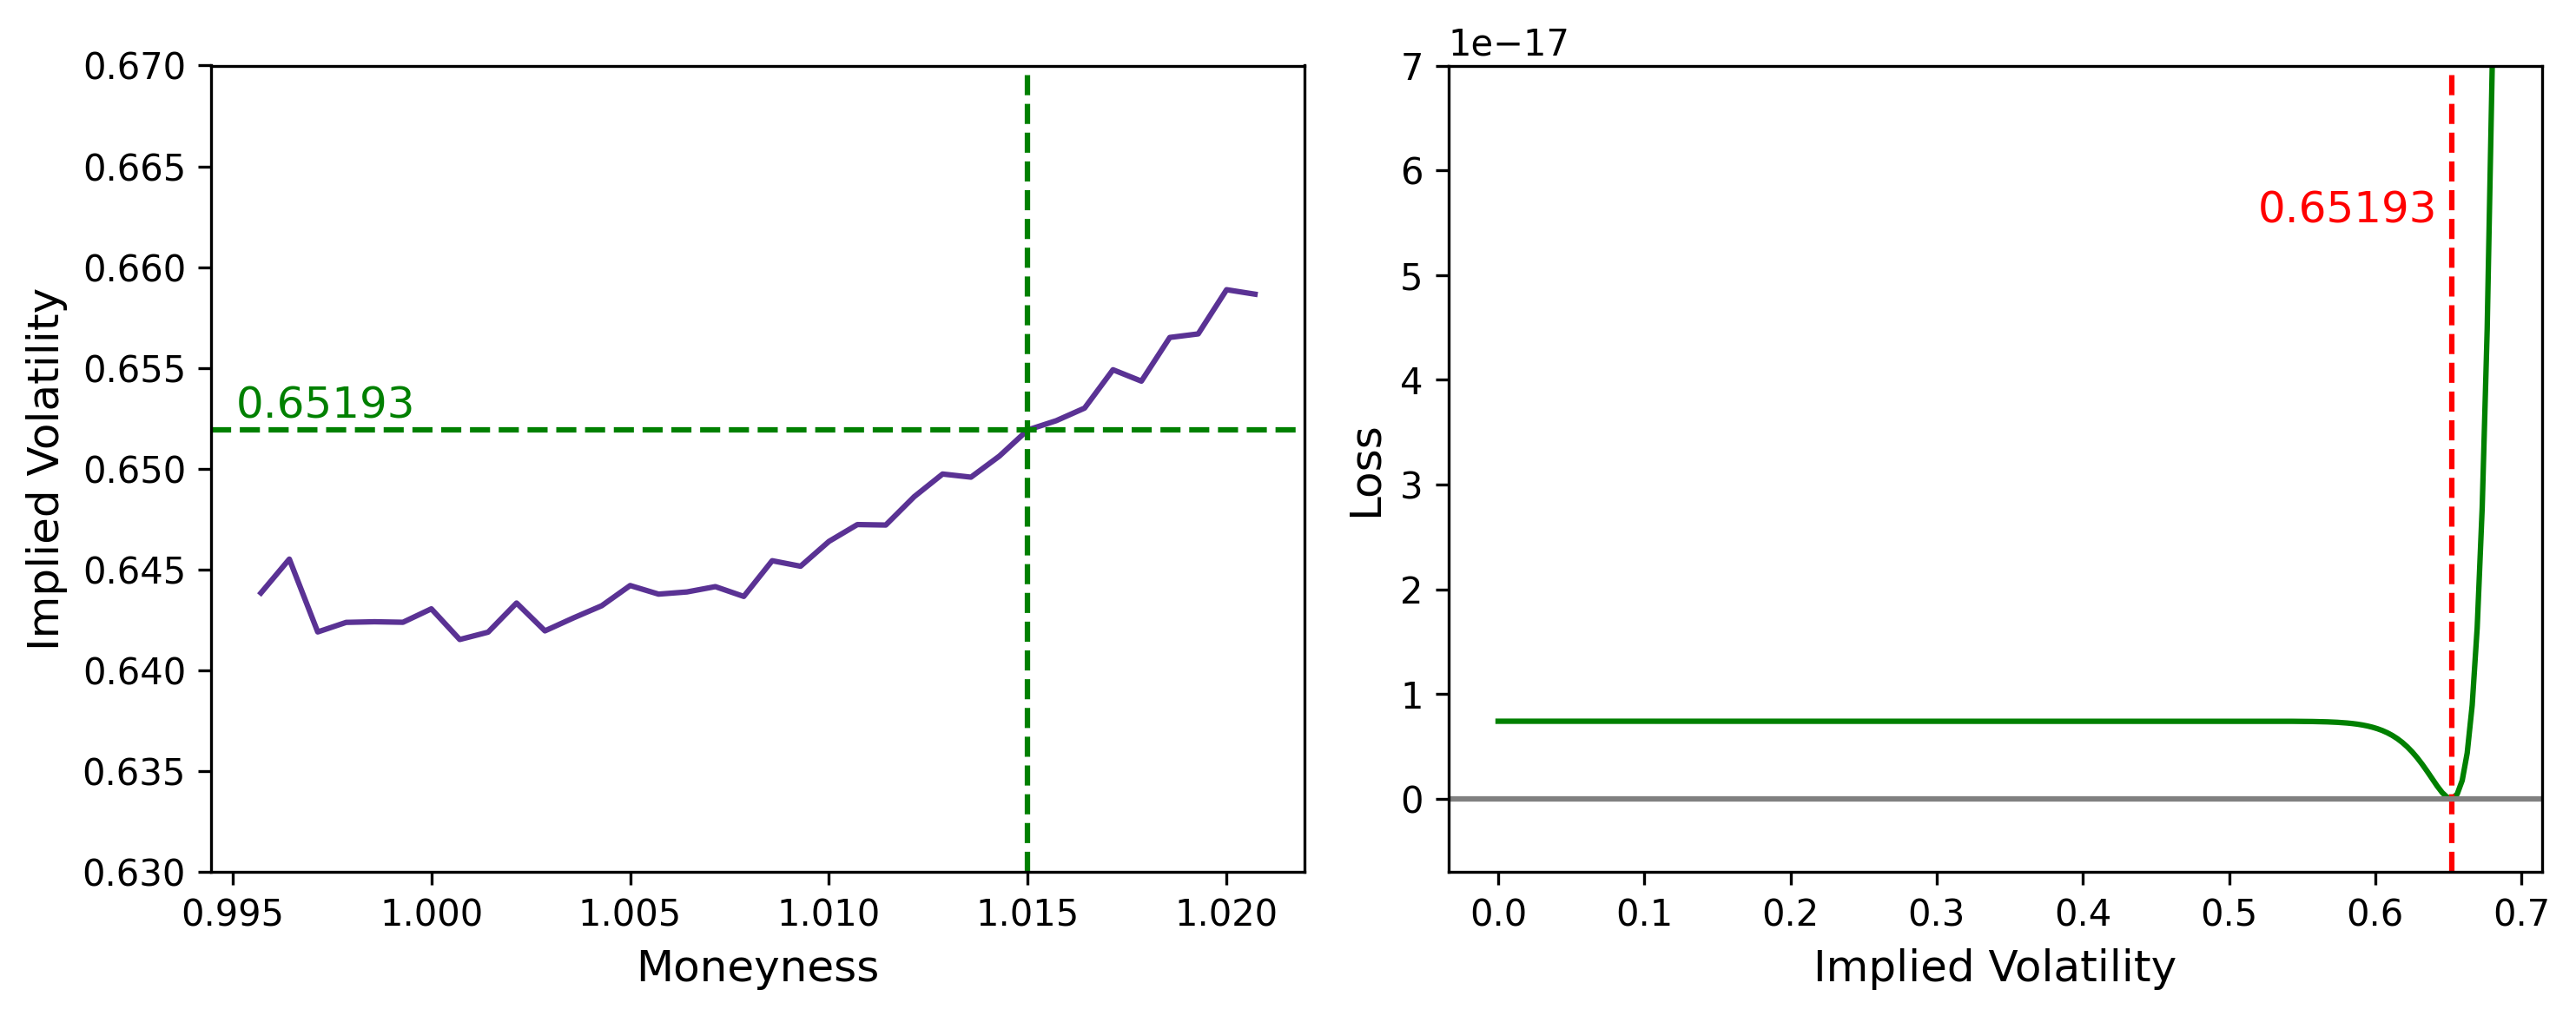

In [100]:
naam = str('./prixSimsResults/CSimSurfaceResults4.csv') #6 different simulations have been performed with slightly different parameters.
Pricesforsmile = pd.read_csv(naam)
if 'Unnamed: 0' in Pricesforsmile.columns:
    Pricesforsmile = Pricesforsmile.drop(columns=['Unnamed: 0'])
    print('! unnamed dropped')

sigmastotry = np.linspace(0.00001, 0.68, 200)
lossvals = []
for sicma in sigmastotry:
    lossvals.append((Bac(0, 700, Strikes[31], sicma ,Tijms[25] ) - Pricesforsmile.iloc[31,25])**2)

min = 10
minidx=0
for i, lval in enumerate(lossvals):
    if min > lval:
        minidx = i
        min = lval

colormap = plt.cm.Purples
colorl = colormap((25 + 17) / 50)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

x_smile = np.asarray(Strikes[4:]) / 700
y_smile = ImpliedsSBRENT[4].iloc[25, 4:]
x_line = Strikes[31] / 700
y_line = ImpliedsSBRENT[4].iloc[25, 31]
fant=12

axes[0].plot(x_smile, y_smile, color=colorl)
axes[0].axvline(x=x_line, color='green', linestyle='--')
axes[0].axhline(y=y_line, color='green', linestyle='--')
axes[0].text(0.9996, y_line + 0.00017, f'{np.round(y_line, 5)}', color='green', ha='right', va='bottom', fontsize=fant)
axes[0].set_xlabel('Moneyness', fontsize=fant)
axes[0].set_ylabel('Implied Volatility', fontsize=fant)
axes[0].set_ylim(0.63, 0.67)

axes[1].plot(sigmastotry, lossvals, color='green')
axes[1].axvline(x=sigmastotry[minidx], color='red', linestyle='--')
axes[1].axhline(y=0, color='gray')
axes[1].text(0.52, 5.5e-17, f'{np.round(ImpliedsSBRENT[4].iloc[25, 31], 5)}', color='red', fontsize=fant)
axes[1].set_xlabel('Implied Volatility', fontsize=fant)
axes[1].set_ylabel('Loss', fontsize=fant)
axes[1].set_ylim(-0.7e-17, 7e-17)

plt.tight_layout()
plt.show()

! unnamed dropped


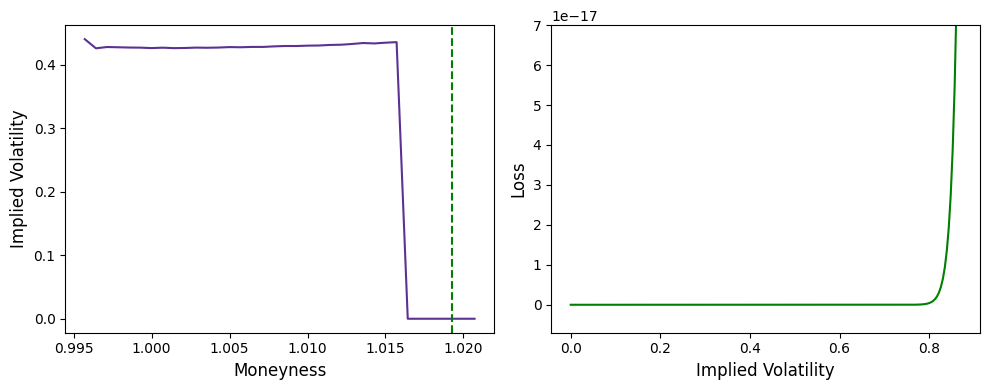

In [105]:
naam = str('./prixSimsResults/CSimSurfaceResults0.csv')
Pricesforsmile = pd.read_csv(naam)
if 'Unnamed: 0' in Pricesforsmile.columns:
    Pricesforsmile = Pricesforsmile.drop(columns=['Unnamed: 0'])
    print('! unnamed dropped')

sigmastotry = np.linspace(0.00001, 0.87, 200)
lossvals = []
for sicma in sigmastotry:
    lossvals.append((Bac(0, 700, Strikes[37], sicma ,Tijms[25] ) - Pricesforsmile.iloc[37,25])**2)

min = 10
minidx=0
for i, lval in enumerate(lossvals):
    if min > lval:
        minidx = i
        min = lval

colormap = plt.cm.Purples
colorl = colormap((25 + 17) / 50)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))


x_smile = np.asarray(Strikes[4:]) / 700
y_smile = ImpliedsSBRENT[0].iloc[25, 4:]
x_line = Strikes[37] / 700
y_line = ImpliedsSBRENT[0].iloc[25, 31]
fant=12

axes[0].plot(x_smile, y_smile, color=colorl)
axes[0].axvline(x=x_line, color='green', linestyle='--')
axes[0].set_xlabel('Moneyness', fontsize=fant)
axes[0].set_ylabel('Implied Volatility', fontsize=fant)

axes[1].plot(sigmastotry, lossvals, color='green')
axes[1].set_xlabel('Implied Volatility', fontsize=fant)
axes[1].set_ylabel('Loss', fontsize=fant)
axes[1].set_ylim(-0.7e-17, 7e-17)

plt.tight_layout()
plt.show()

Plot of Implied volatility surface, some might be broken due to unstable retrieval of the IV.

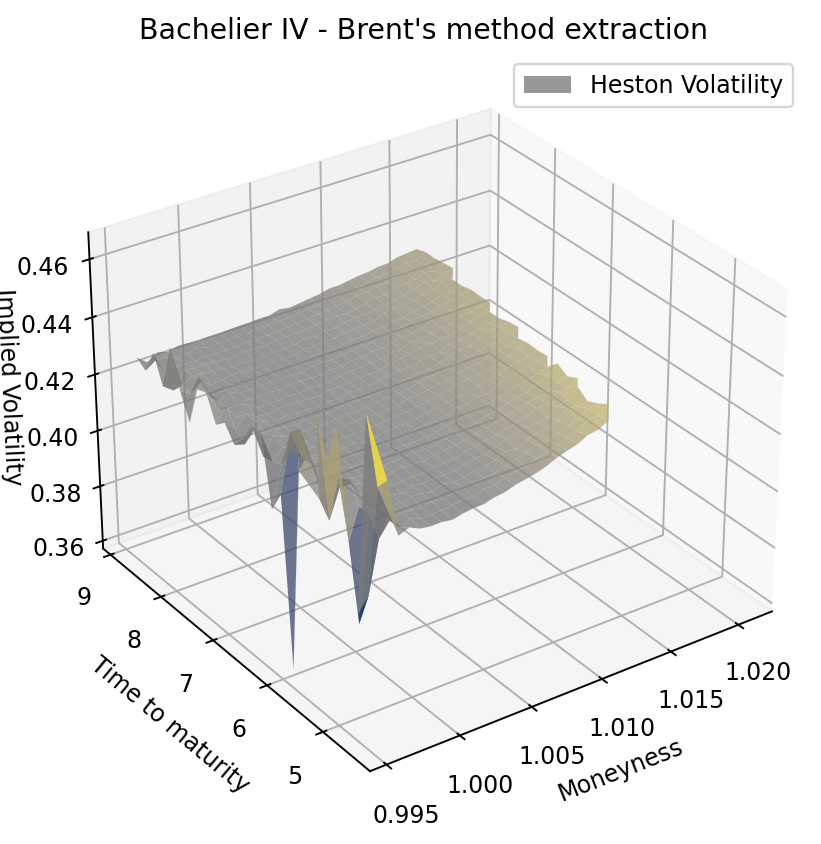

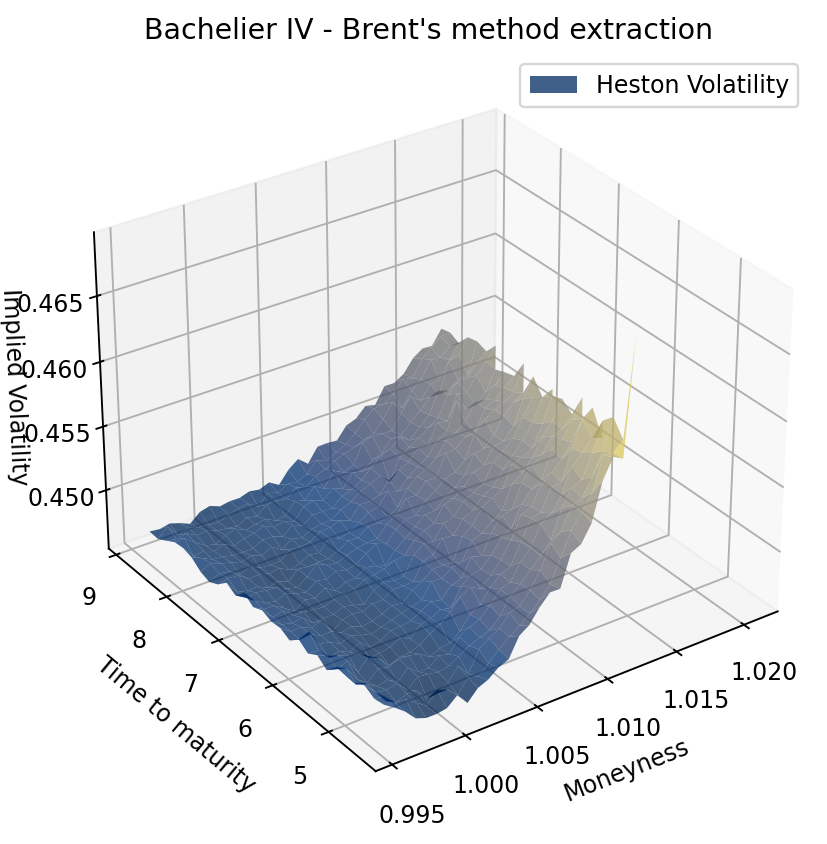

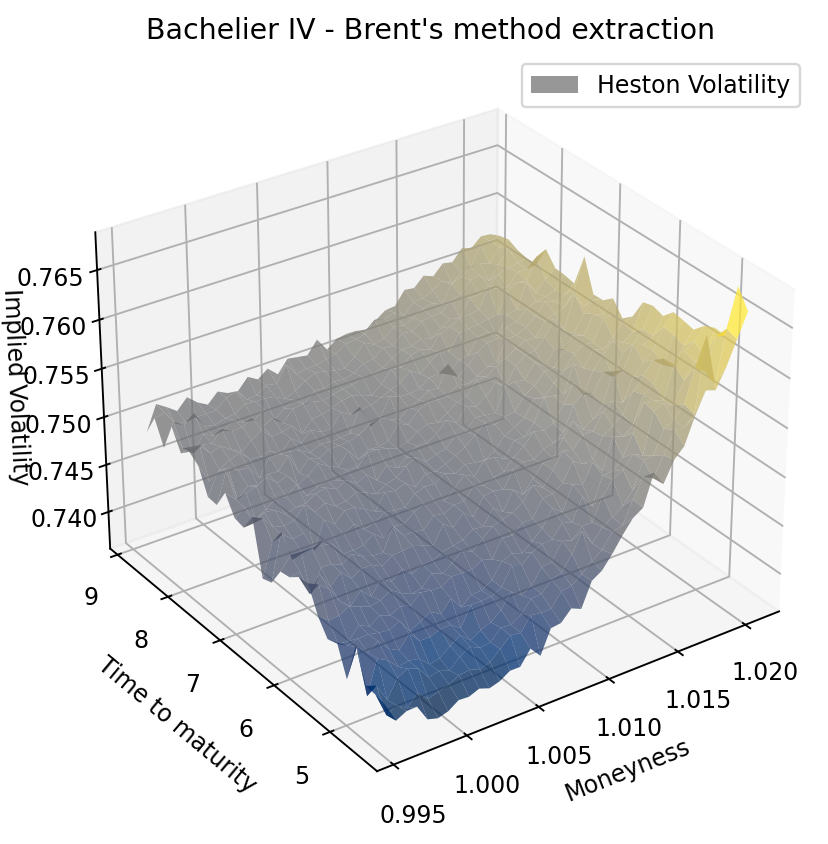

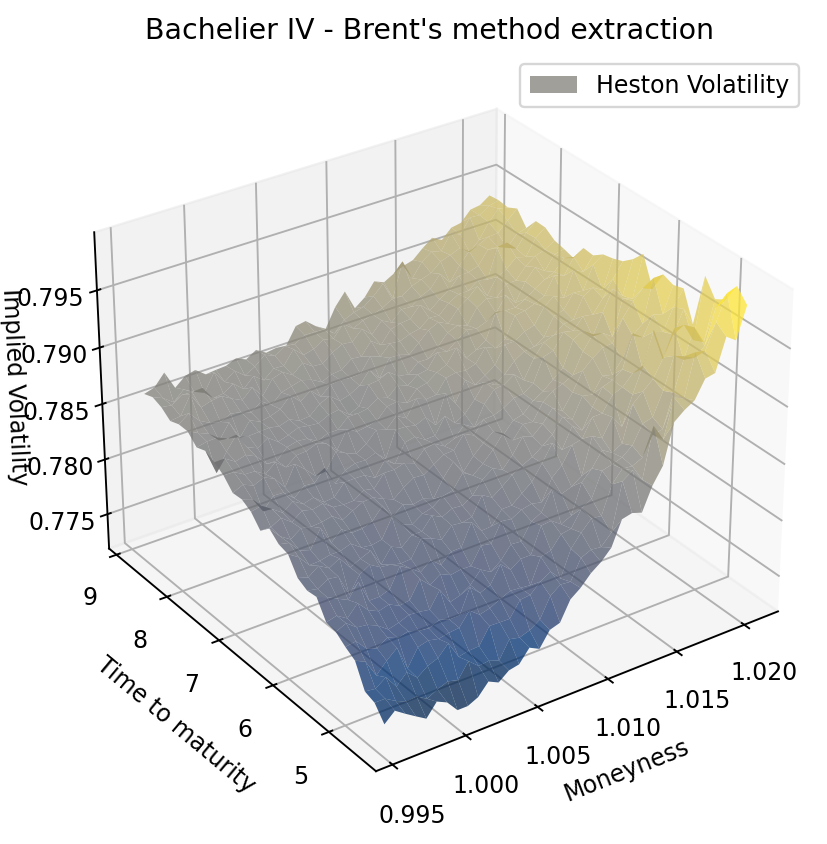

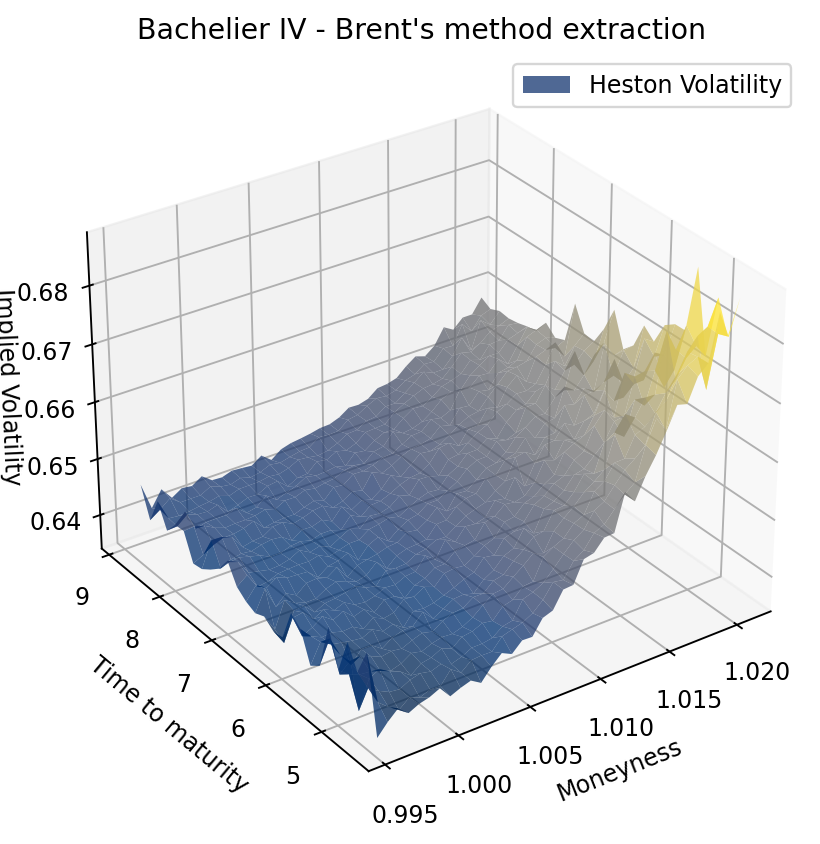

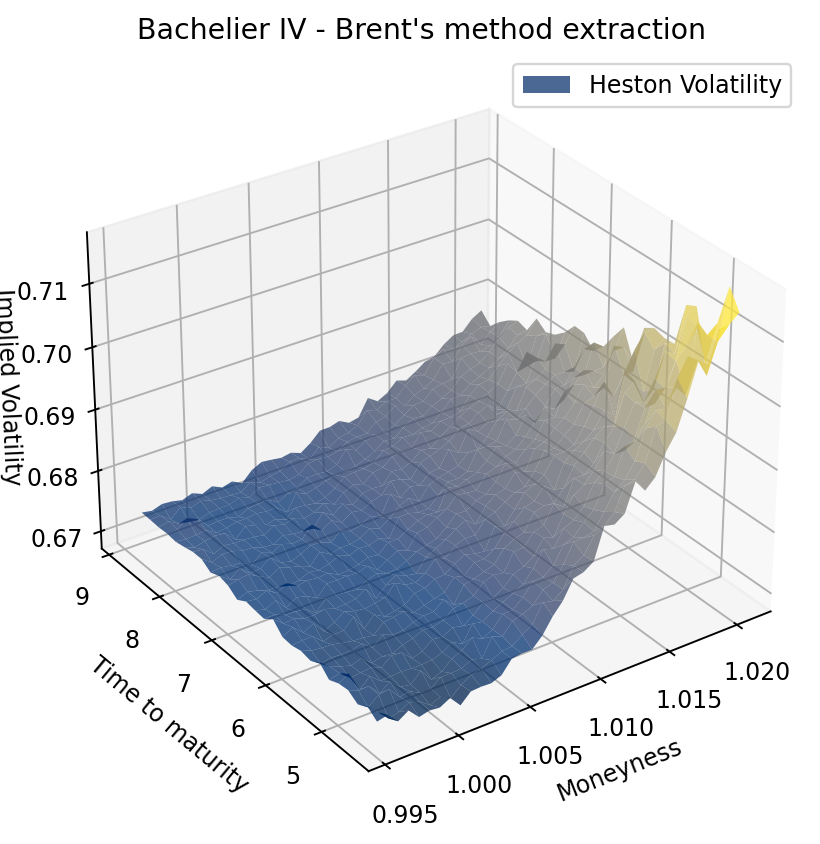

In [110]:
minS= 4
minT= 3
x = np.asarray(Strikes[minS:])/700
y = Tijms[minT:]
X,Y = np.meshgrid(x,y)

for i in range(6):
    ZbrentLN = ImpliedsSBRENTLN[i].iloc[minT:, minS:]
    Zbrent = ImpliedsSBRENT[i].iloc[minT:, minS:]

    ZbrentLN_masked = np.ma.masked_where(ZbrentLN < 0.25, ZbrentLN)
    Zbrent_masked = np.ma.masked_where(Zbrent < 0.25, Zbrent)

    fig = plt.figure(dpi=170)
    fig.set_size_inches(5, 5)

    ax = fig.add_subplot(111,projection='3d')
    #ax.plot_surface(X, Y, ZbrentLN_masked, alpha=0.5, cmap='plasma' , label='Log-Normal Volatility')
    ax.plot_surface(X, Y, Zbrent_masked, alpha=0.75, cmap='cividis', label='Heston Volatility')

    ax.set_title("Bachelier IV - Brent's method extraction")
    ax.set_ylabel('Time to maturity')
    ax.set_xlabel('Moneyness')
    ax.set_zlabel('Implied Volatility', labelpad=1)  # Increase padding
    ax.legend()
    ax.view_init( azim=-125)  # a different angle is more useful for the visualization
    plt.tight_layout()


# SABR - Calibration & Surface

In [53]:
#unavoidable use of global variables for this implementation

def sabr_lognormal_expansion(K, alpha, rho, nu):
    F=700
    beta=0
    log_KF = np.log(K / F)
    lambda_ = (nu / alpha) * F**(1 - beta)
    
    first_order = -0.5 * (1 - beta - rho * lambda_) * log_KF
    second_order = (1 / 12) * ((1 - beta)**2 + (2 - 3 * rho**2) * lambda_**2) * log_KF**2

    sigma = (alpha / F**(1 - beta)) * (1 + first_order + second_order)
    return sigma


def HaganIVret(K, alpha, rho, nu):
    beta = 0
    Ffit = 700
    K = np.asarray(K)  # ensure array

    logFK = np.log(Ffit / K)
    FK_beta = (Ffit * K) ** ((1 - beta) / 2)
    z = (nu / alpha) * FK_beta * logFK
    x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

    den = FK_beta * (1 + ((1 - beta)**2 / 24) * logFK**2 + ((1 - beta)**4 / 1920) * logFK**4)
    correction = (
        1
        + ((1 - beta)**2 / 24) * (alpha**2) / (FK_beta**2)
        + (rho * beta * nu * alpha) / (4 * FK_beta)
        + ((2 - 3 * rho**2) * nu**2 / 24)
    ) * Tfit

    sigma = (alpha / den) * (z / x_z) * correction
    return sigma  # array of same shape as K


SABR model calibration step

In [163]:
usedStrikes = np.asarray(Strikes[4:]) #choosing only from strikes for which our IV retrieved is stable
IV_slice = ImpliedsSBRENT[4] 
HestonParameters = []
covariances = []
p0 = [0.01, -0.5, 0.5]

for i, Tfit in enumerate(Tijms):
    y_data = np.asarray(IV_slice.iloc[i, 4:])
    aproxs,covs = curve_fit(sabr_lognormal_expansion, usedStrikes, y_data, p0=p0)
    HestonParameters.append(aproxs)
    covariances.append(covs)


In [164]:
alphav=[]
rhov=[]
nuv=[]
for covm in covariances:
    alphav.append(covm[0,0])
    rhov.append(covm[1,1])
    nuv.append(covm[2,2])

print('aplha variance:', np.mean(alphav))
print('rho variance:', np.mean(rhov))
print('nu variance:', np.mean(nuv))

aplha variance: 0.07775553825291502
rho variance: 0.00016685757998307648
nu variance: 0.3275608820499421


In [172]:
mre = 0
for i in range(len(HestonParameters)):
    mre += np.mean(np.abs((ImpliedsSSABR.iloc[i, 0:] - ImpliedsSBRENT[4].iloc[i, 4:]) / ImpliedsSBRENT[4]))

mre = mre/len(HestonParameters)
print(mre)

0.00559473320452689


SABR implied vol surface construction

In [165]:
ImpliedsSSABR = np.zeros((len(Tijms), len(usedStrikes)))
for i, T in enumerate(Tijms):
    sabrParams=HestonParameters[i]
    alphaSABR = sabrParams[0]
    rhoSABR = sabrParams[1]
    nuSABR = sabrParams[2]
    for j, stk in enumerate(usedStrikes):
        ImpliedsSSABR[i,j] = sabr_lognormal_expansion(stk, alphaSABR, rhoSABR, nuSABR)

ImpliedsSSABR = pd.DataFrame(ImpliedsSSABR)

Plot of sample Smile against extraction of classic Bachelier model IV

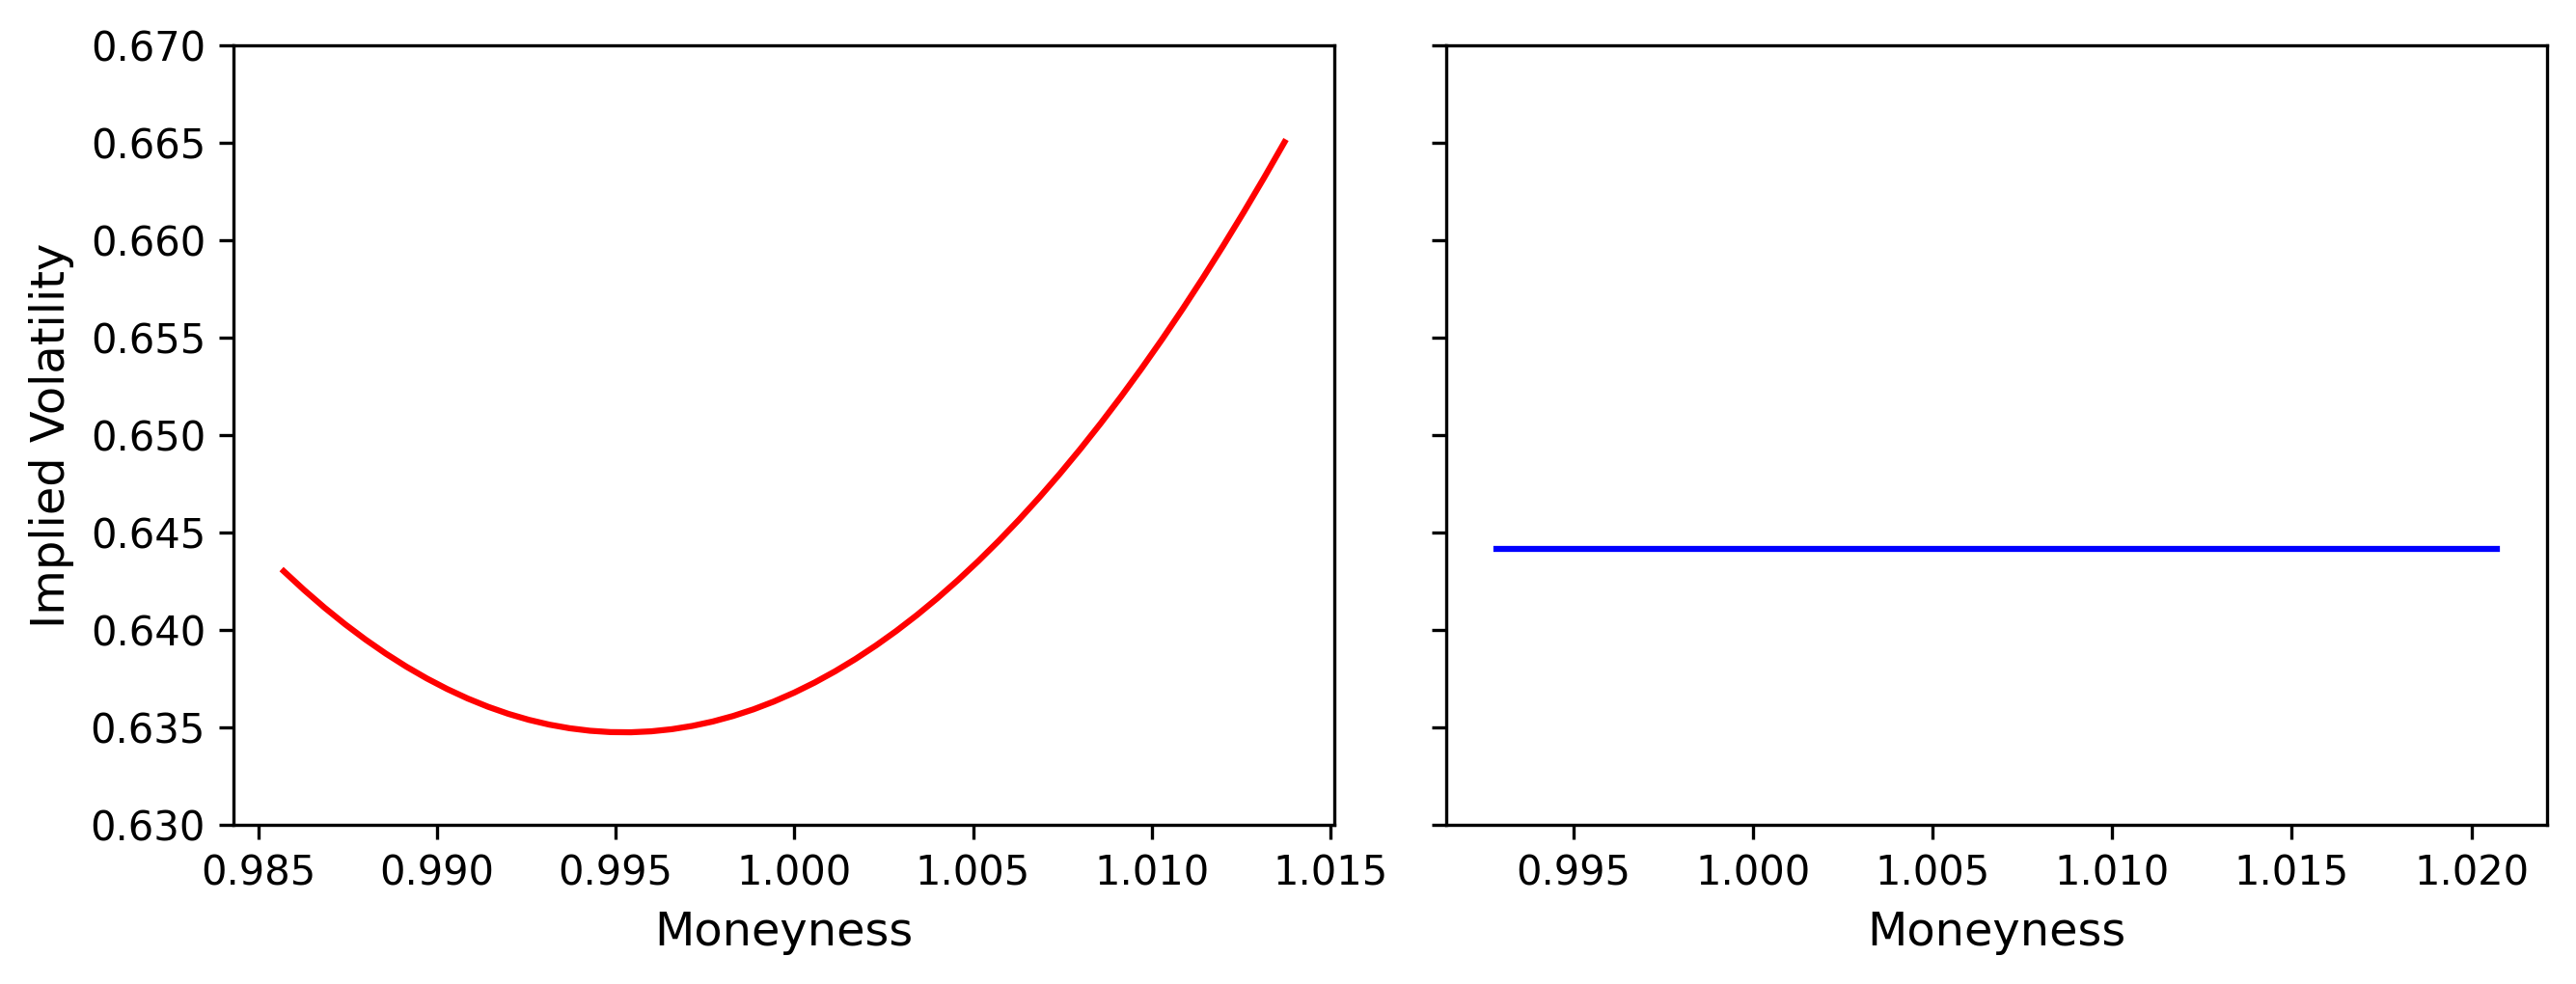

In [166]:
NincrementsK = 50
NStrikes = []
k1 = 690
fant = 11.5
strinc = 20/NincrementsK
for i in range(NincrementsK):
    NStrikes.append(k1)
    k1 = k1+strinc

sabrParams=HestonParameters[0]
alphaSABR = sabrParams[0]
rhoSABR = sabrParams[1]
nuSABR = sabrParams[2]
smileSABR = []# :-D 
for s in NStrikes:
    smileSABR.append(sabr_lognormal_expansion(s, alphaSABR, rhoSABR, nuSABR))

prixfixed = pd.read_csv('prixSimsResults/originalBacSim.csv')
fixedvols = []
for i, p in enumerate(prixfixed['0']):
    fixedvols.append(ImpliedBrent(700, 5, Strikes[i], p))
    
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True, dpi=300)

axes[0].plot(np.asarray(NStrikes)/700, smileSABR, color='Red')
axes[0].set_xlabel('Moneyness', fontsize=fant)
axes[0].set_ylabel('Implied Volatility', fontsize=fant)
axes[0].set_ylim(0.63, 0.67)

axes[1].plot(np.asarray(Strikes)/700, fixedvols, color='Blue')
axes[1].set_xlabel('Moneyness', fontsize=fant)
axes[1].set_ylim(0.63, 0.67)

plt.tight_layout()
plt.show()



Smile retrieval vs Brent Graph

[ 4.47288836e+02 -3.10739990e-02 -2.05788030e+01]
[ 4.49017370e+02 -9.07111825e-02 -1.16263394e+01]


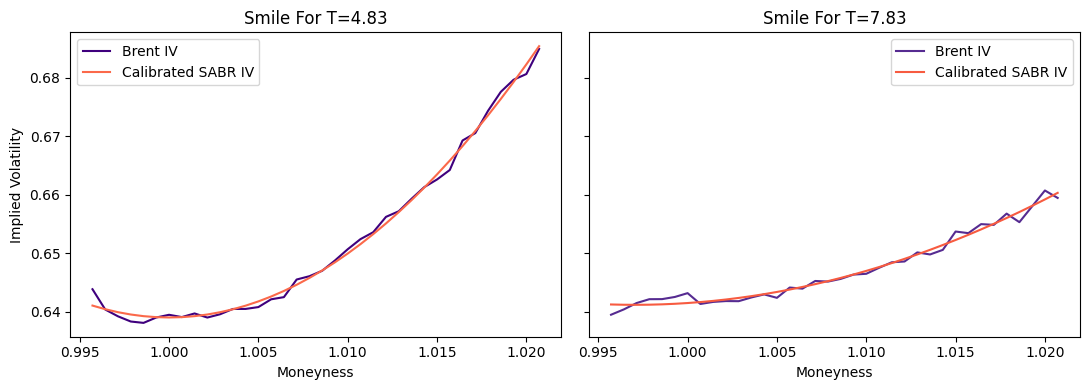

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

colormap1 = plt.cm.Purples
colormap2 = plt.cm.Reds
colormapchoi = plt.cm.Greens

x_vals = np.asarray(Strikes[4:]) / 700

# Plot Brent
for i in range(5,6):
    color = colormap1((i + 50) / 50)
    axes[0].plot(x_vals, ImpliedsSBRENT[4].iloc[i, 4:], color=color, label='Brent IV')
    color = colormap2((i+20) / 50)
    axes[0].plot(x_vals, ImpliedsSSABR.iloc[i, 0:], color=color, label='Calibrated SABR IV')
    print(HestonParameters[i])
axes[0].set_title('Smile For T=' + str(np.round(Tijms[i],2)))
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Implied Volatility')
axes[0].legend()

# Plot SABR
for i in range(23,24):
    print(HestonParameters[i])
    color = colormap1((i + 20) / 50)
    axes[1].plot(x_vals, ImpliedsSBRENT[4].iloc[i, 4:], color=color, label='Brent IV')
    color = colormap2((i+4) / 50)
    axes[1].plot(x_vals, ImpliedsSSABR.iloc[i, 0:], color=color, label='Calibrated SABR IV')
axes[1].set_title('Smile For T=' + str(np.round(Tijms[i], 2)))
axes[1].set_xlabel('Moneyness')
axes[1].legend()

plt.tight_layout()
plt.legend
plt.show()


Additional Graphs

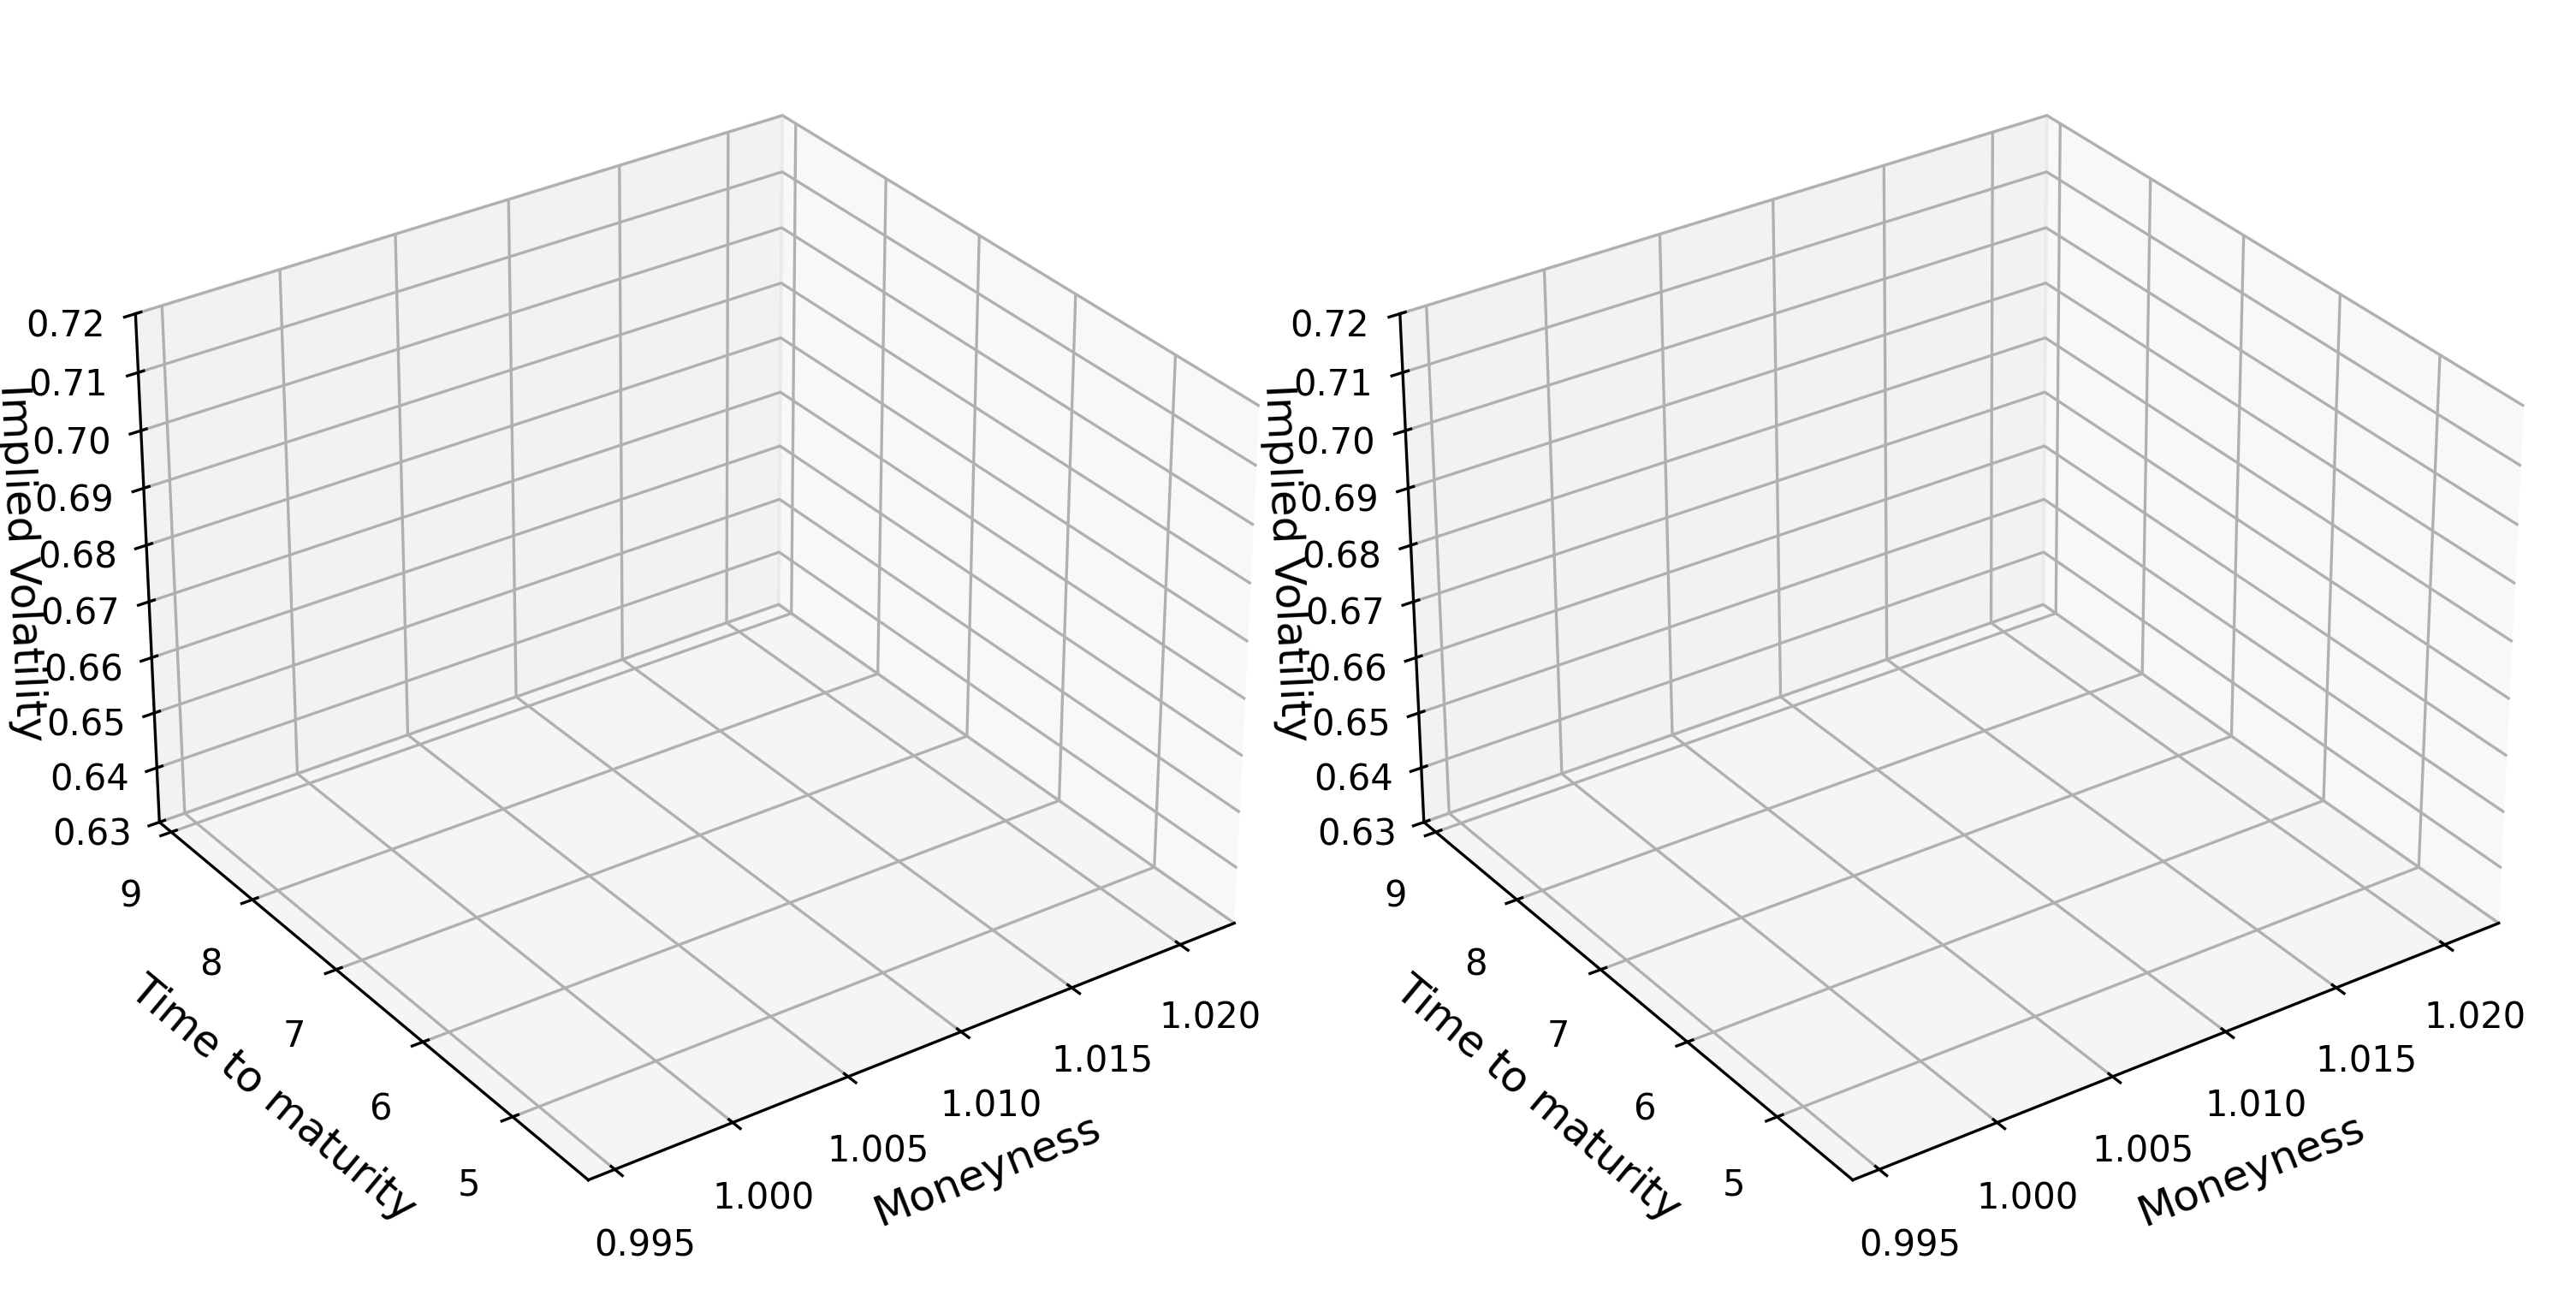

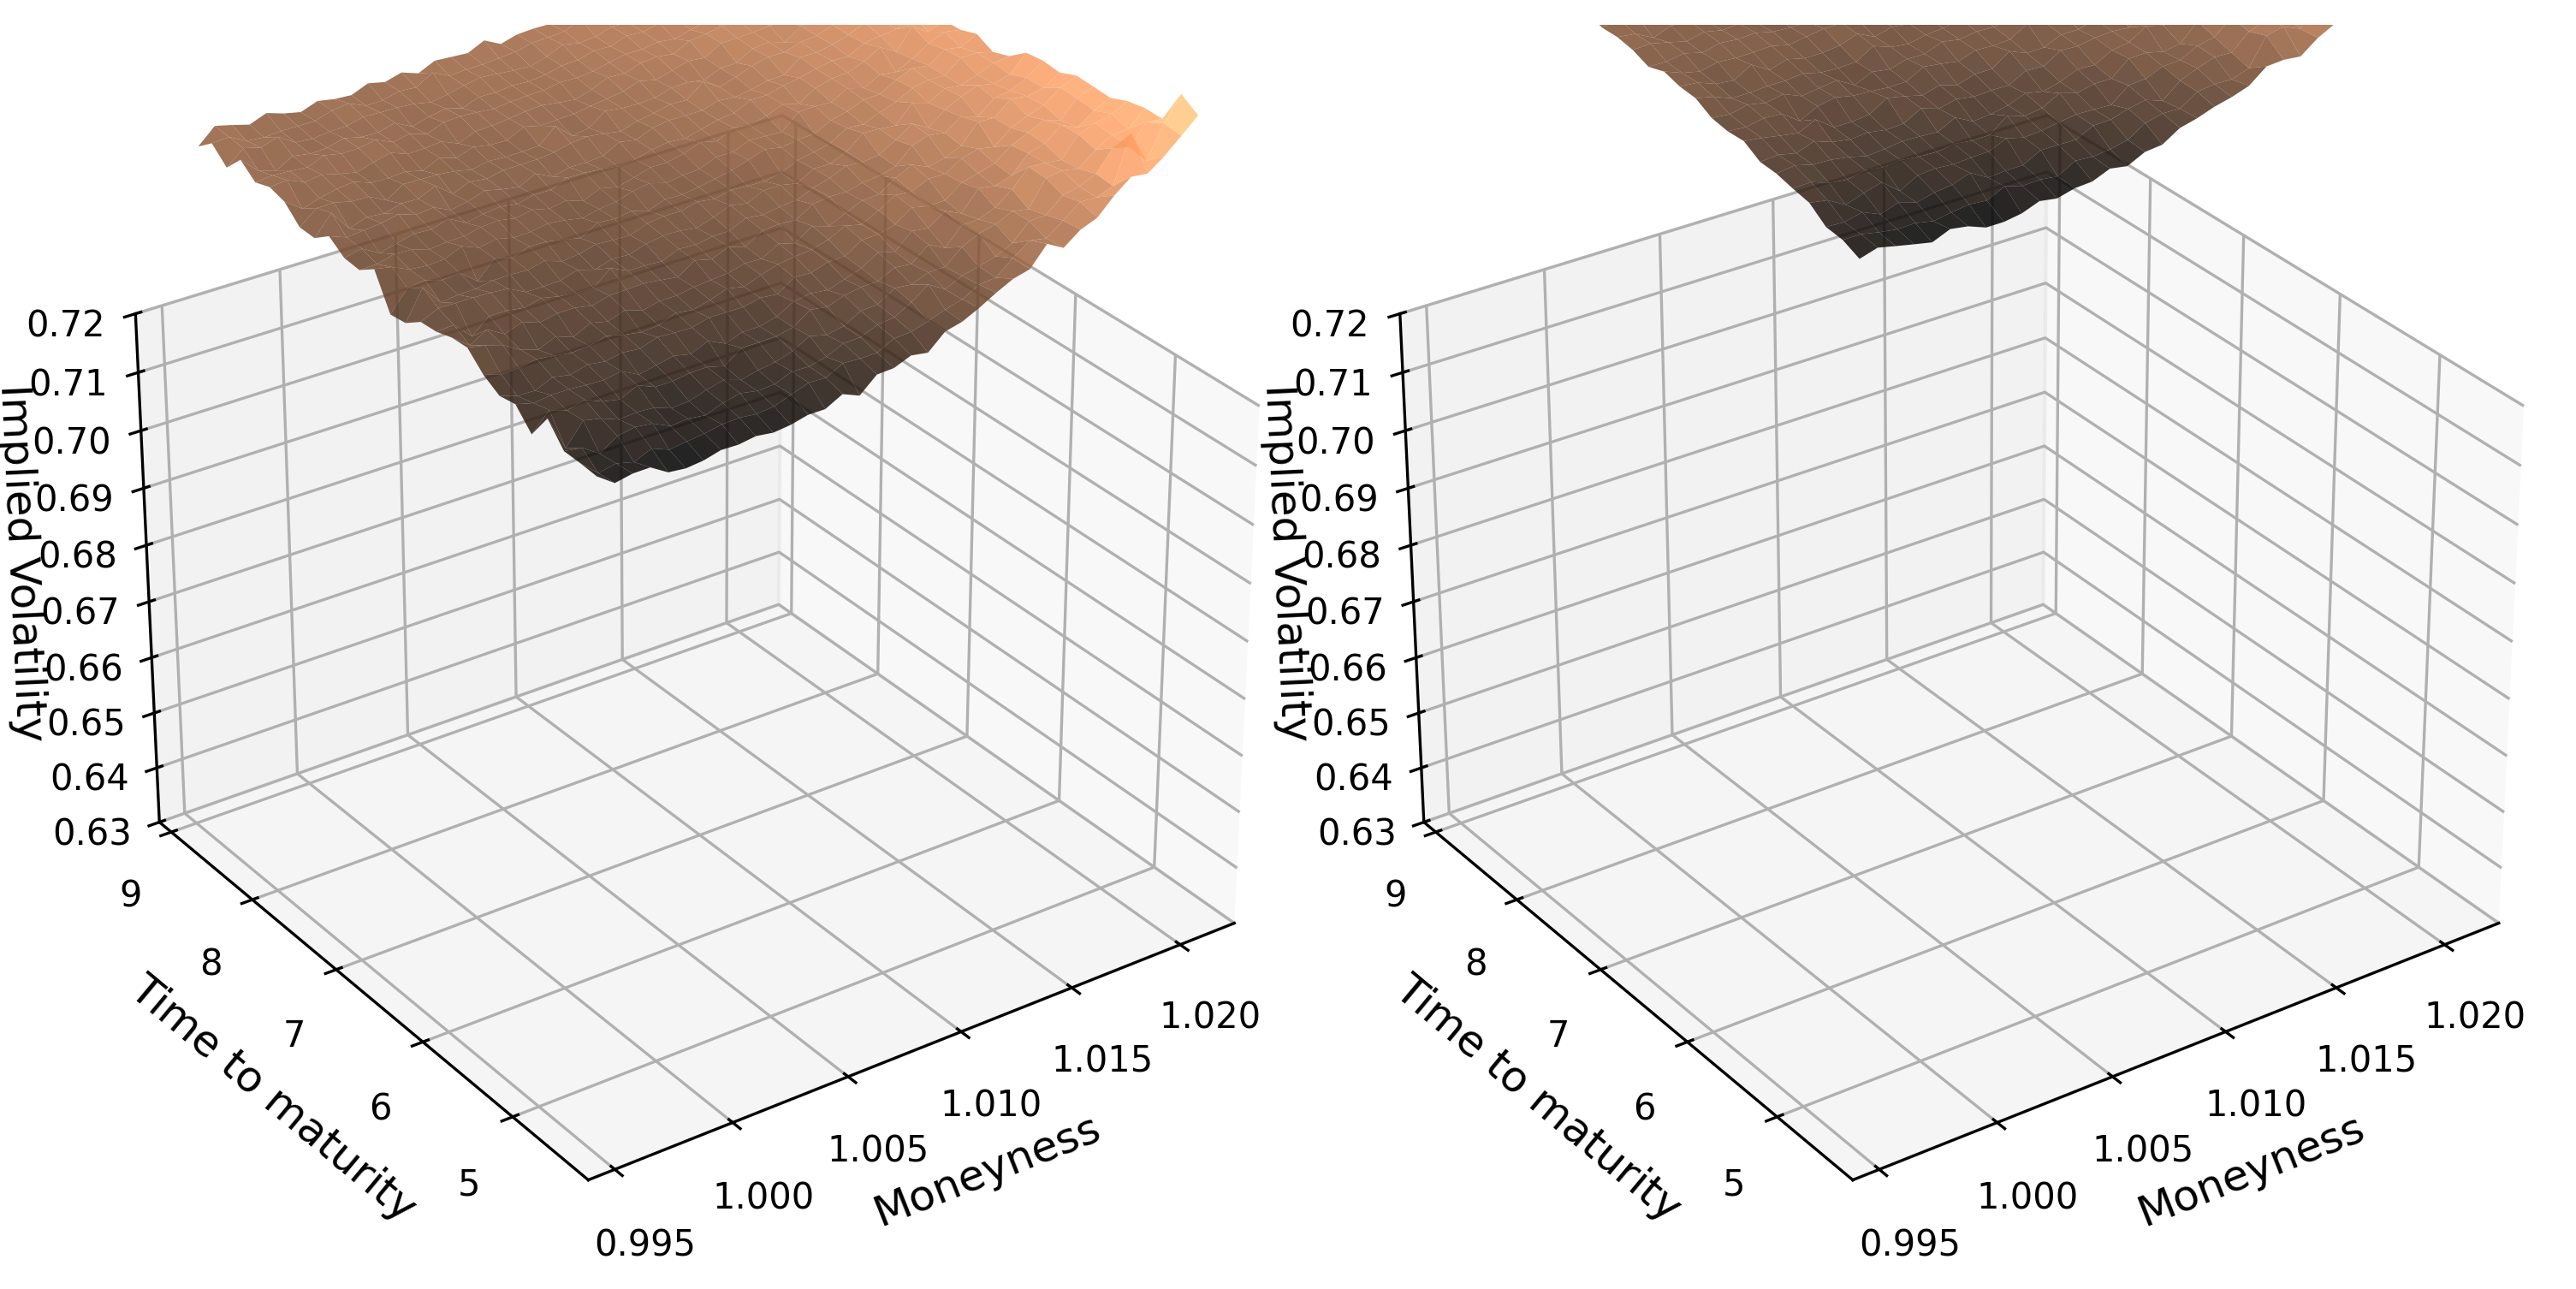

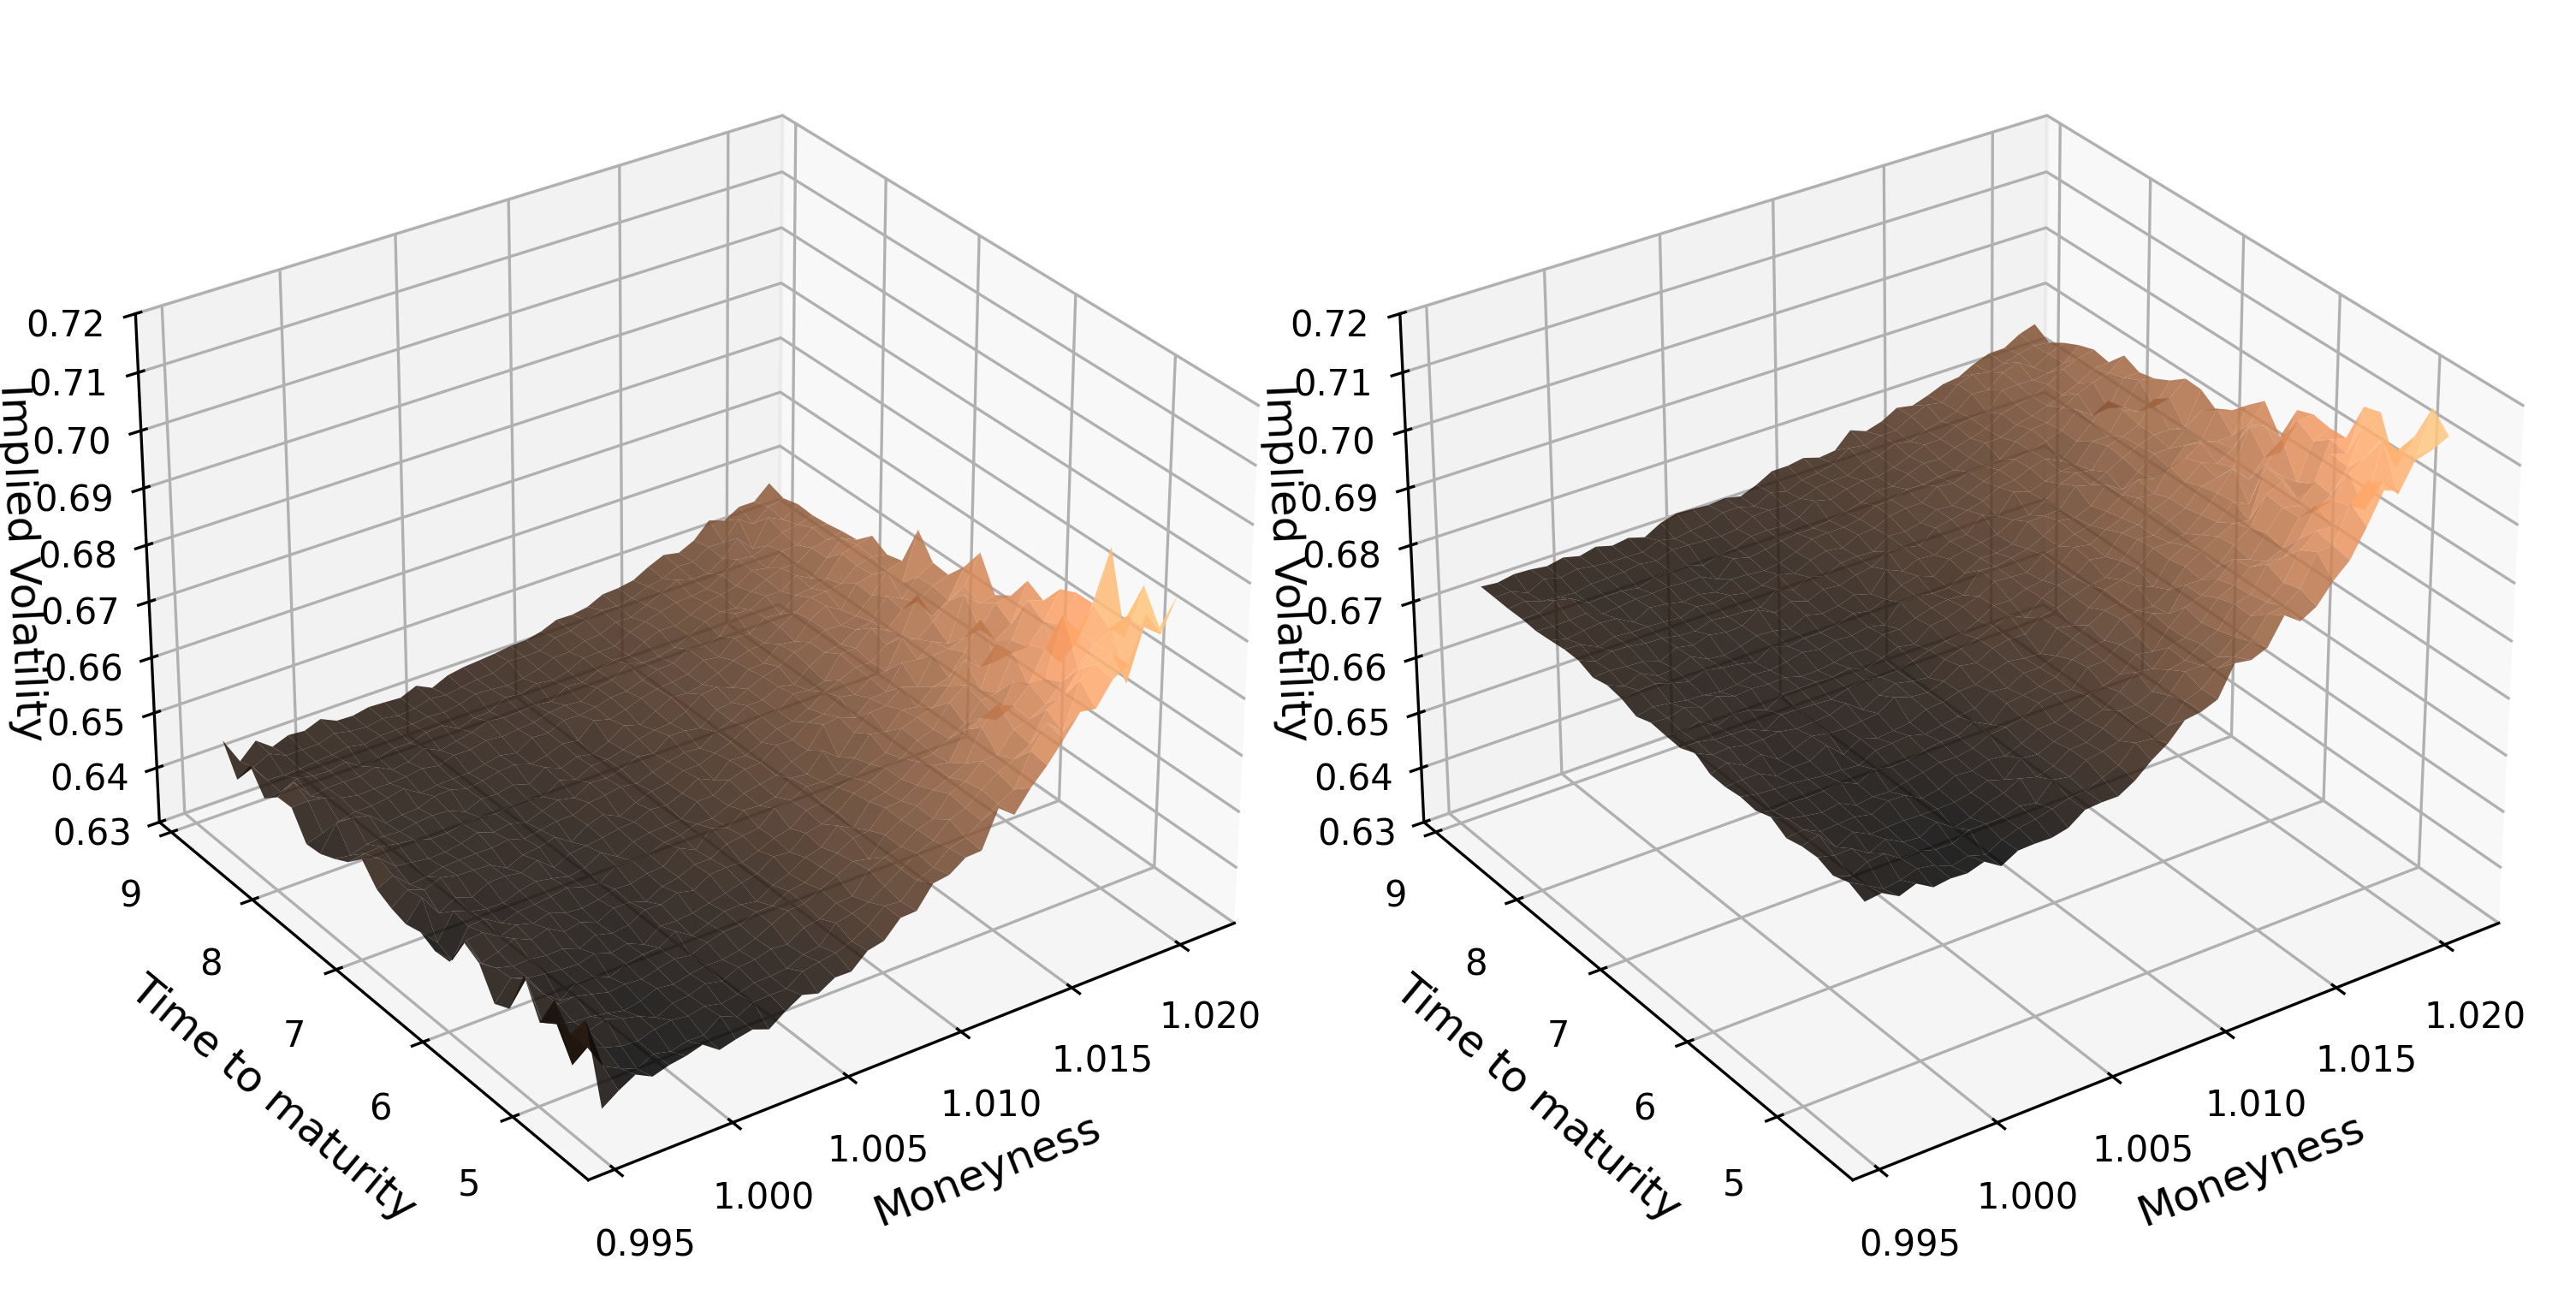

In [168]:
fant=12
for i in range(0, 6, 2): 
    fig = plt.figure(figsize=(10, 12), dpi=300)

    for j, subplot_index in enumerate([i, i + 1]):
        Zbrent = ImpliedsSBRENT[subplot_index].iloc[minT:, minS:]
        Zbrent_masked = np.ma.masked_where(Zbrent < 0.25, Zbrent)

        ax = fig.add_subplot(1, 2, j + 1, projection='3d')
        ax.plot_surface(X, Y, Zbrent_masked, alpha=0.85, cmap='copper')
        
        # if (subplot_index%2)==0:
        #     ax.set_title("Bachelier IV - Brent's method extraction (a)")
        # elif (subplot_index%2)==1:
        #     ax.set_title("Bachelier IV - Brent's method extraction (b)")
        ax.set_ylabel('Time to maturity', fontsize=fant)
        ax.set_xlabel('Moneyness',fontsize=fant)
        ax.set_zlabel('Implied Volatility',fontsize=fant)
        ax.set_zlabel('Implied Volatility', labelpad=0.15, fontsize=fant)

        ax.view_init(azim=-125)
        ax.set_zlim(0.63, 0.72)

    plt.tight_layout()
    plt.show()


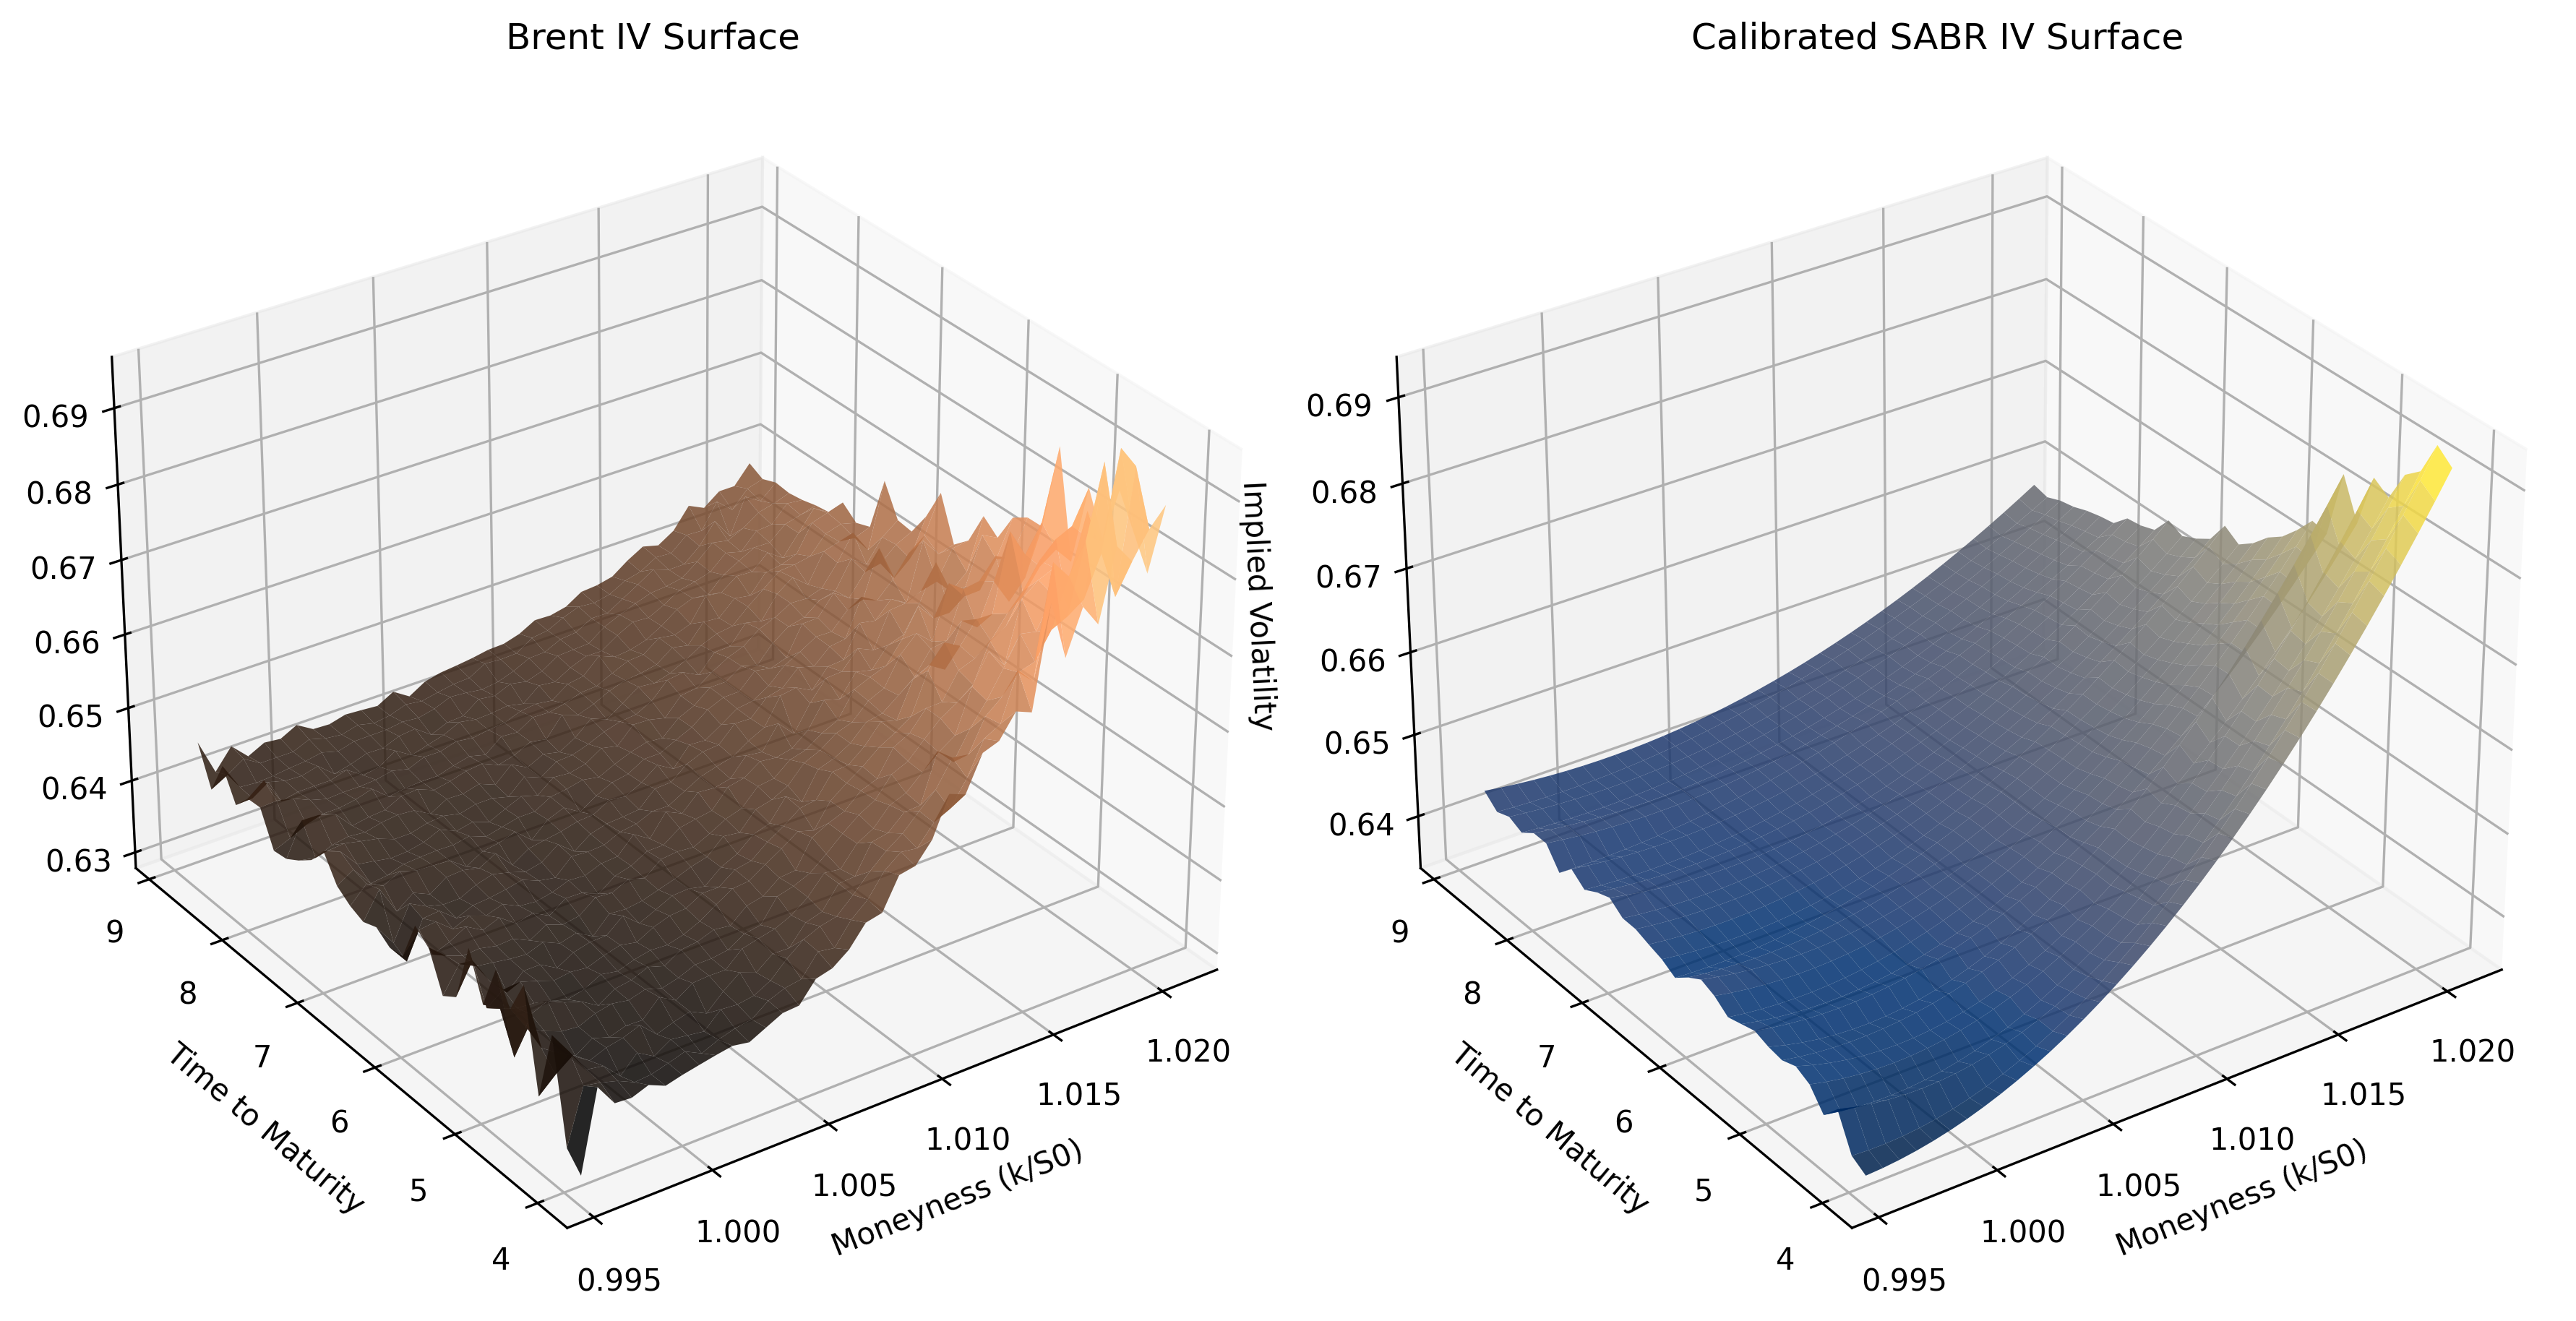

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D projection
import numpy as np

x = Strikes[4:]
y = Tijms
X, Y = np.meshgrid(x, y)
Zbrent = ImpliedsSBRENT[4].iloc[:, 4:]
ZSABR = ImpliedsSSABR.iloc[:, :]  # Adjust indexing if needed

fig = plt.figure(figsize=(12, 6), dpi=300)

# --- Brent IV surface ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X / 700, Y, Zbrent, alpha=0.85, cmap='copper')
ax1.set_title("Brent IV Surface")
ax1.set_xlabel("Moneyness (k/S0)")
ax1.set_ylabel("Time to Maturity")
ax1.set_zlabel("Implied Volatility", labelpad=9)
ax1.view_init(azim=-125)

# --- SABR IV surface ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X / 700, Y, ZSABR, alpha=0.85, cmap='cividis')
ax2.set_title("Calibrated SABR IV Surface")
ax2.set_xlabel("Moneyness (k/S0)")
ax2.set_ylabel("Time to Maturity")
ax2.set_zlabel("Implied Volatility", labelpad=9)
ax2.view_init(azim=-125)

plt.tight_layout()
plt.show()


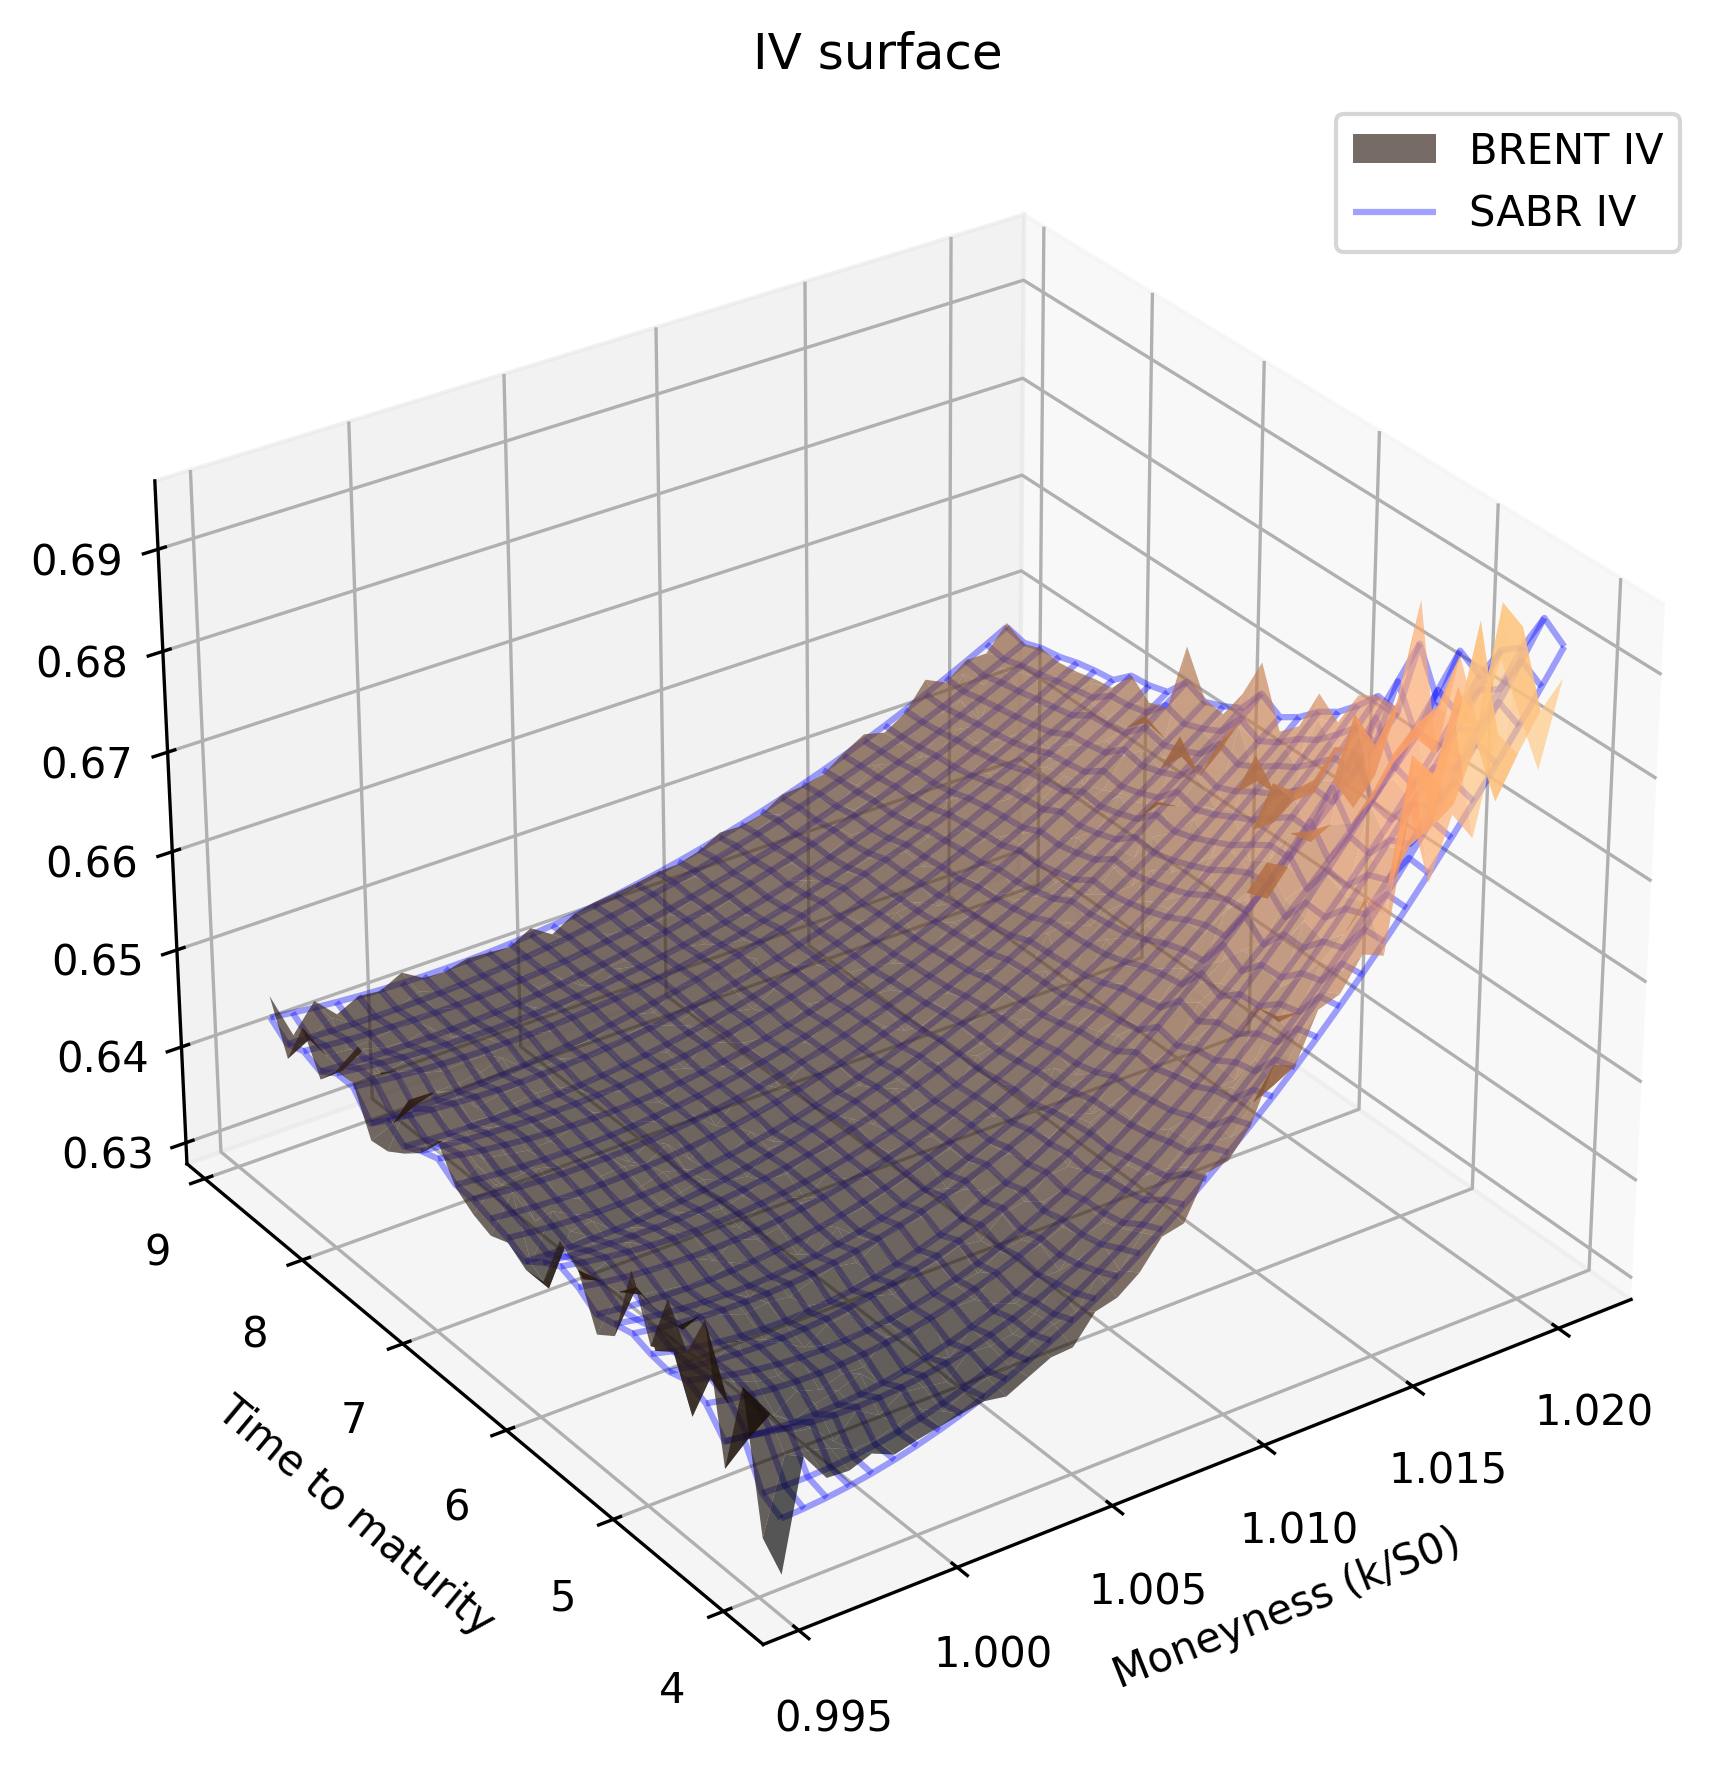

In [60]:
#IV surface from market data vs Brent 
x = Strikes[4:]
y = Tijms
X,Y = np.meshgrid(x,y)
Zbrent = ImpliedsSBRENT[4].iloc[:, 4:]

fig = plt.figure(dpi=300)
fig.set_size_inches(6,6)

ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X/700, Y, Zbrent, alpha=0.65, cmap='copper', label='BRENT IV')
ax.plot_wireframe(X/700, Y, ImpliedsSSABR.iloc[:,:], alpha=0.37, color='blue', label='SABR IV')

ax.set_title('IV surface')
ax.set_ylabel('Time to maturity')
ax.set_xlabel('Moneyness (k/S0)')
ax.set_zlabel('Implied Volatility',  labelpad=9)
ax.legend()


plt.tight_layout()

ax.view_init( azim=-125) 

In [61]:
prixserial = pd.read_csv('./prixSimsResults/serialmethods.csv')

In [62]:
display(prixserial)

Unnamed: 0                          Method  Average Price  \
0           0          Serial Raw Monte Carlo       1.505466   
1           1  Serial Conditional Monte Carlo       1.501937   

   Prices Standard Deviation  Exectution Time  
0                   2.226164       385.937501  
1                   0.000271       262.235308

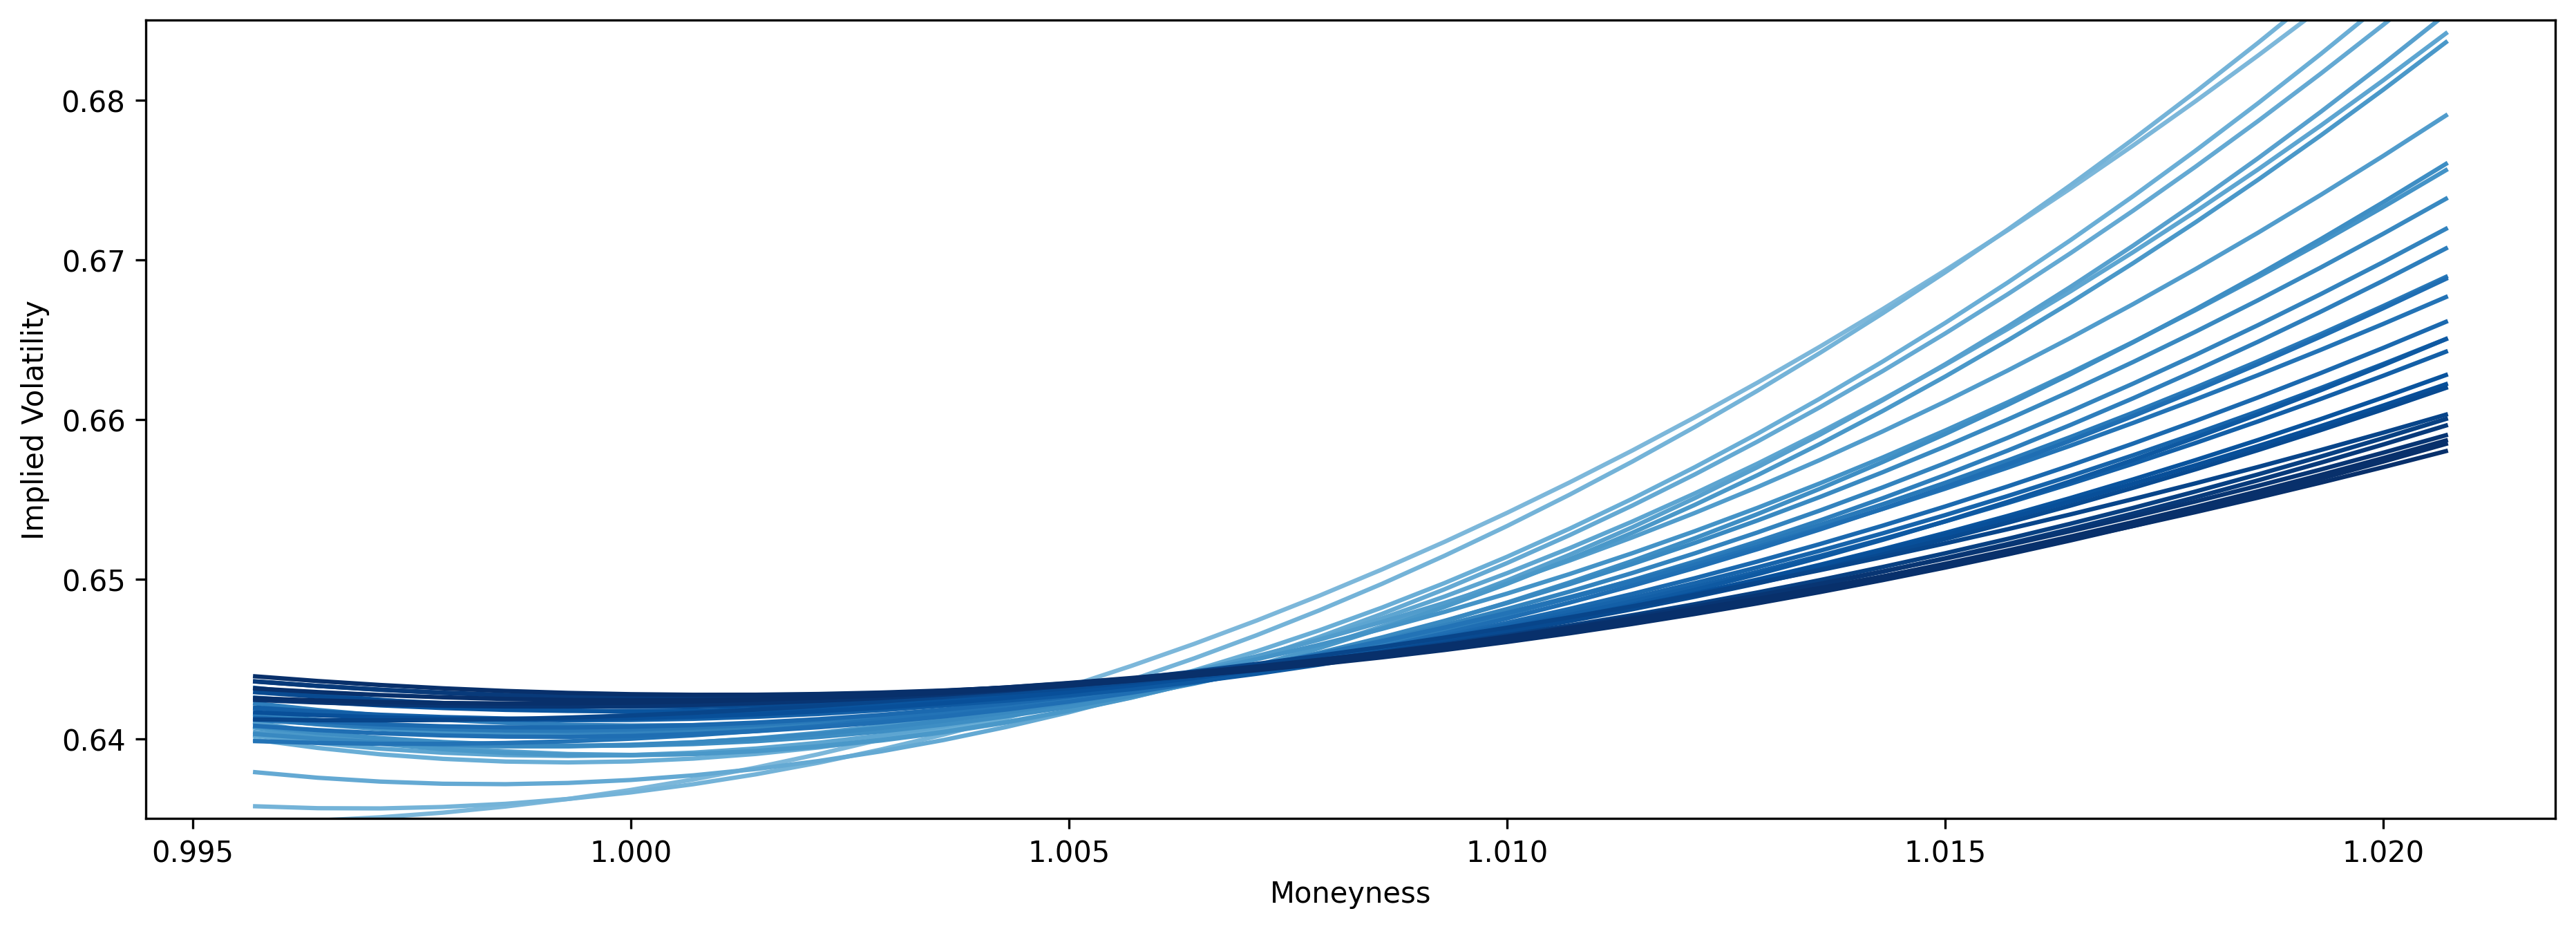

In [63]:
colormap = plt.cm.Blues
plt.figure(figsize=(15, 5), dpi=300)

for i in range(30):
    colorl = colormap((i + 23) / 50)
    plt.plot(np.asarray(Strikes[4:]) / 700, ImpliedsSSABR.iloc[i, :], color=colorl)

plt.ylim(0.635, 0.685)  # Corrected line
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.show()


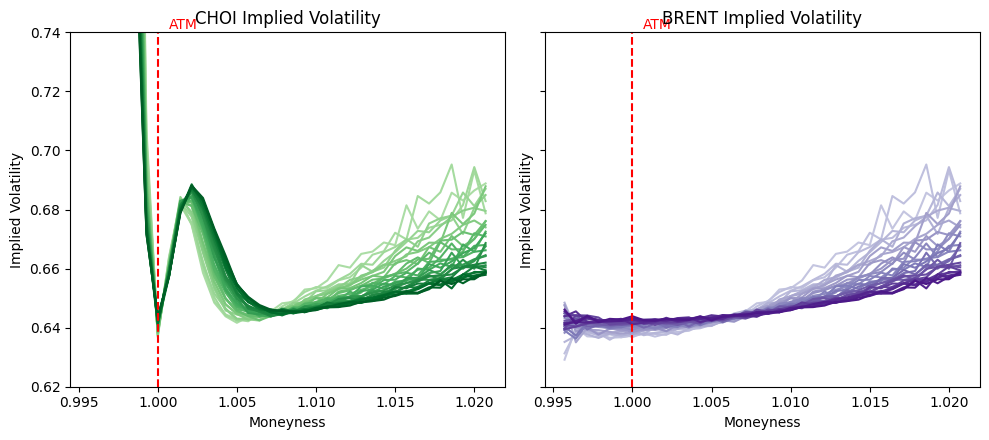

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

colormap1 = plt.cm.Purples
colormapchoi = plt.cm.Greens

x_vals = np.asarray(Strikes[4:]) / 700

for i in range(30):
    color = colormapchoi((i + 17) / 50)
    axes[0].plot(x_vals, ImpliedsSCHOI[4].iloc[i, 4:], color=color)
axes[0].set_title('CHOI Implied Volatility')
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Implied Volatility')
axes[0].axvline(x=1, color='red', linestyle='--')
axes[0].text(1.0025, 0.74, 'ATM', color='red', ha='right', va='bottom')



# Plot Brent
for i in range(30):
    color = colormap1((i + 17) / 50)
    axes[1].plot(x_vals, ImpliedsSBRENT[4].iloc[i, 4:], color=color)

axes[1].axvline(x=1, color='red', linestyle='--')


axes[1].set_title('BRENT Implied Volatility')
axes[1].set_xlabel('Moneyness')
axes[1].set_ylabel('Implied Volatility')
axes[1].text(1.0025, 0.74, 'ATM', color='red', ha='right', va='bottom')

axes[1].set_ylim(0.62, 0.74)



plt.tight_layout()
plt.show()

In [65]:

colormap2 = plt.cm.Reds
# Plot SABR
for i in range(30):
    color = colormap2((i+4) / 50)
    axes[0].plot(x_vals, ImpliedsSSABR.iloc[i,:], color=color)
axes[0].set_title('Calibrated SABR Implied Volatility')
axes[0].set_xlabel('Moneyness')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

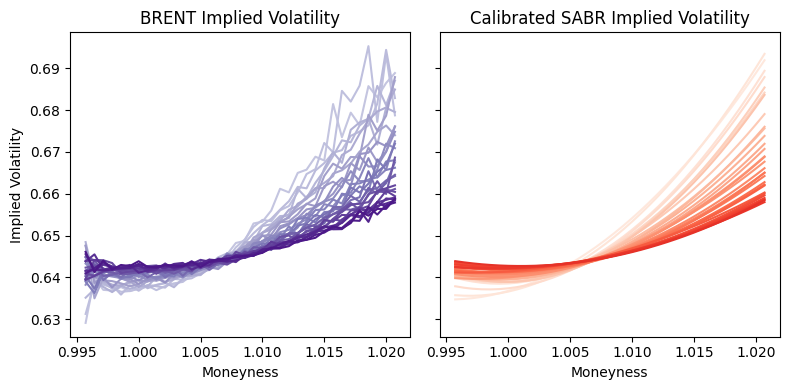

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

colormap1 = plt.cm.Purples
colormap2 = plt.cm.Reds
colormapchoi = plt.cm.Greens

x_vals = np.asarray(Strikes[4:]) / 700

# Plot Brent
for i in range(30):
    color = colormap1((i + 17) / 50)
    axes[0].plot(x_vals, ImpliedsSBRENT[4].iloc[i, 4:], color=color)
axes[0].set_title('BRENT Implied Volatility')
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Implied Volatility')

# Plot SABR
for i in range(30):
    color = colormap2((i+4) / 50)
    axes[1].plot(x_vals, ImpliedsSSABR.iloc[i,:], color=color)
axes[1].set_title('Calibrated SABR Implied Volatility')
axes[1].set_xlabel('Moneyness')

plt.tight_layout()
plt.show()

In [67]:
print('alpha    rho     nu')
print(HestonParameters[5])
print(HestonParameters[23])

alpha    rho     nu
[4.47288837e+02 3.10739153e-02 2.05788070e+01]
[ 4.49017370e+02 -9.07111631e-02 -1.16263401e+01]


MC results loading and comparison

In [68]:
serial = pd.read_csv('./prixSimsResults/serialmethods.csv')
matricial = pd.read_csv('./prixSimsResults/matricialmethods.csv')
parallel = pd.read_csv('./prixSimsResults/parallelmethods.csv')
combined = pd.concat([serial, matricial, parallel], ignore_index=True)
display(combined)

Unnamed: 0                             Method  Average Price  \
0               0             Serial Raw Monte Carlo       1.505466   
1               1     Serial Conditional Monte Carlo       1.501937   
2               0          Matricial Raw Monte Carlo       1.494563   
3               1  Matricial Conditional Monte Carlo       1.501923   
4               0                                NaN            NaN   
...           ...                                ...            ...   
17999       17995                                NaN            NaN   
18000       17996                                NaN            NaN   
18001       17997                                NaN            NaN   
18002       17998                                NaN            NaN   
18003       17999                                NaN            NaN   

       Prices Standard Deviation  Exectution Time       Raw      Cond  
0                       2.226164       385.937501       NaN       NaN  
1                       0.000271       262.235308       NaN       NaN  
2                       2.189593         4.362767       NaN       NaN  
3                       0.000263         5.278157       NaN       NaN  
4                            NaN              NaN  3.182353  1.502371  
...                          ...              ...       ...       ...  
17999                        NaN              NaN  1.904712  1.509874  
18000                        NaN              NaN -0.397282  1.514253  
18001                        NaN              NaN  0.605794  1.480208  
18002                        NaN              NaN  0.436802  1.500956  
18003                        NaN              NaN  1.145159  1.508254  

[18004 rows x 7 columns]

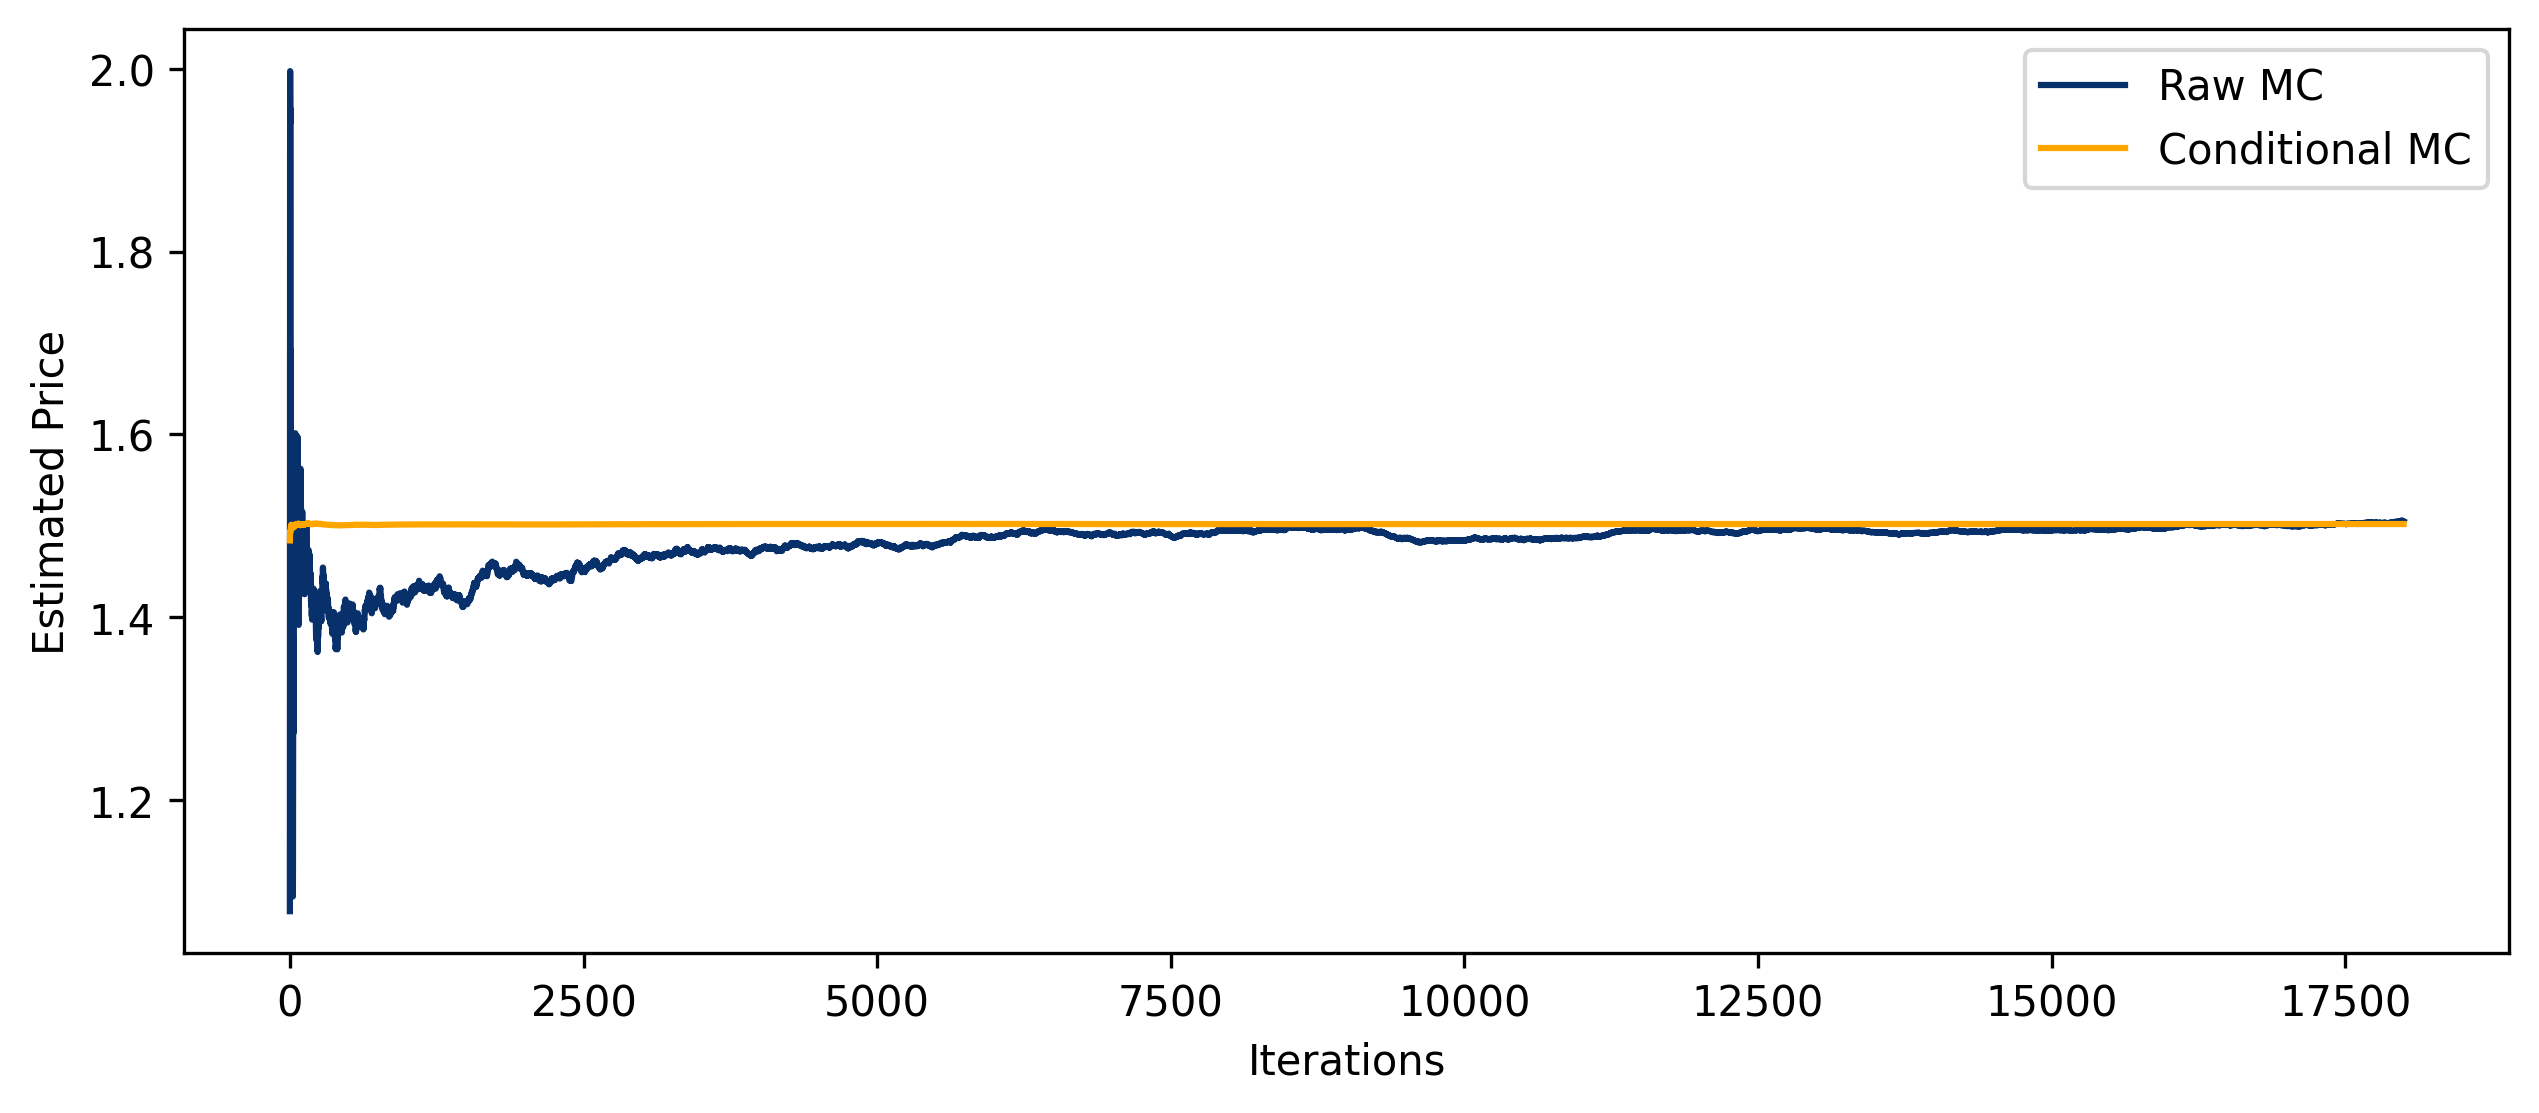

In [161]:
prixconv = pd.read_csv('prixSimsResults/convergenceNumbers.csv')
convrawvals = np.asarray(prixconv['Raw'].values)
convcondvals = np.asarray(prixconv['Cond'].values)

convergenceRaw = []
convergenceCond = []
for i in range(len(prixconv['Raw'].values) - 1):
    convergenceRaw.append(np.mean(convrawvals[:i+1]))
    convergenceCond.append(np.mean(convcondvals[:i+1]))
    colormap = plt.cm.Blues
plt.figure(figsize=(10, 4), dpi=300)

colorl = colormap(12345678)
plt.plot(convergenceRaw[3:], color=colorl, label='Raw MC')
plt.plot(convergenceCond[3:], color='Orange', label='Conditional MC')
plt.xlabel('Iterations')
plt.ylabel('Estimated Price')
plt.legend()
plt.show()